<a href="https://colab.research.google.com/github/TinhToQuang/homepage/blob/main/BWA2025_HCMC/GDGC_Unleashing_Gemini_2.0's_Search_and_Multimodal_Capabilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to this Codelab! We'll explore how to leverage Gemini 2.0's built-in Google Search tool for real-time information retrieval, combine it with multimodal capabilities, and build practical applications with the Google Gen AI SDK.


# Setup Section

## 1. Install Dependencies and Setup Environment

### Install the Google Gen AI SDK
### !pip install -U -q google-genai matplotlib pandas plotly python-dateutil

In [1]:
!pip install -U -q google-genai matplotlib pandas plotly python-dateutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.7/159.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, HTML, Markdown
from google.colab import userdata

print("--- 1. Setting up environment ---")
print("# Required packages installed. Setting up your API key next.")

# Load the API key from Colab secrets
# For security, we use Colab's userdata feature
try:
    # @markdown Make sure you have saved your Google AI API key as a Colab secret named 'GOOGLE_API_KEY'
    os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
    print("✅ API key loaded successfully!")
except Exception as e:
    print(f"❌ Error loading API key: {e}")
    print("Please set up your API key by following these steps:")
    print("1. Go to https://ai.google.dev/ to get your API key")
    print("2. In Colab, go to 'Secrets' in the left sidebar")
    print("3. Add a new secret named 'GOOGLE_API_KEY' with your key as the value")
    print("4. Re-run this cell")


--- 1. Setting up environment ---
# Required packages installed. Setting up your API key next.
✅ API key loaded successfully!


# Gemini Model Initialization
## 2. Initialize Gemini 2.0 Model

In [57]:
from google import genai

# Initialize the client with your API key
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'],
                     http_options={'api_version': 'v1alpha'})


# Available models - uncomment the one you want to use
MODEL = 'gemini-2.5-flash-preview-04-17'  # Fast, good for quick searches and responses
MODEL_PRO = 'gemini-2.5-pro-exp-03-25'  # More capable but slower, and often being overloaded
#MODEL = 'gemini-2.0-flash-thinking-exp-01-21'

print(f"✅ Using model: {MODEL}")
print("# Note: Different models have different capabilities and pricing.")
print("# The 'flash' model is faster while 'pro' is more capable.")

✅ Using model: gemini-2.5-flash-preview-04-17
# Note: Different models have different capabilities and pricing.
# The 'flash' model is faster while 'pro' is more capable.


# Helper Functions
## 3. Define Helper Functions for Response Display

In [35]:
def show_parts(response):
    """Display various parts of a Gemini response including text, code, and search results."""
    parts = response.candidates[0].content.parts

    if parts is None:
        finish_reason = response.candidates[0].finish_reason
        print(f'Finish reason: {finish_reason}')
        return

    for part in response.candidates[0].content.parts:
        if part.text:
            display(Markdown(part.text))
        elif hasattr(part, 'executable_code') and part.executable_code:
            display(Markdown(f'```python\n{part.executable_code.code}\n```'))
        else:
            print("Other part type:")
            print(json.dumps(part.model_dump(exclude_none=True), indent=2))

    # Display search results if any
    grounding_metadata = response.candidates[0].grounding_metadata
    if grounding_metadata and grounding_metadata.search_entry_point:
        print("\n📊 Search Results Used:")
        display(HTML(grounding_metadata.search_entry_point.rendered_content))

In [36]:
def visualize_search_usage(responses):
    """Create a visualization of how many searches were used in responses."""
    search_counts = []

    # Process multiple responses to count search usage
    for i, resp in enumerate(responses):
        count = 0
        if hasattr(resp.candidates[0], 'grounding_metadata') and resp.candidates[0].grounding_metadata:
            meta = resp.candidates[0].grounding_metadata
            if hasattr(meta, 'search_entry_point') and meta.search_entry_point:
                # Count the number of search queries
                count = len(meta.search_entry_point.references) if hasattr(meta.search_entry_point, 'references') else 1
        search_counts.append(count)

    # Create a simple bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(search_counts)), search_counts, color='skyblue')
    plt.xlabel('Query Number')
    plt.ylabel('Number of Searches Used')
    plt.title('Search Utilization per Query')
    plt.xticks(range(len(search_counts)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [6]:
print("✅ Helper functions defined for displaying responses and visualizing search usage")
print("# These functions will help us examine how Gemini uses search and processes information.")

✅ Helper functions defined for displaying responses and visualizing search usage
# These functions will help us examine how Gemini uses search and processes information.


# Basic Search Example

## 4. Comparing Responses With and Without Search



In [37]:
print("\n--- 4. Basic Search Comparison Demo ---")
print("# Let's compare how Gemini responds with and without search capabilities")

# Chat without search
regular_chat = client.chats.create(model=MODEL)

q4 = "What are the latest developments in quantum computing?"
print("\n📝 Query without search: '{}'".format(q4))
regular_response = regular_chat.send_message(q4)
print("\n🤖 Response WITHOUT search tool:")
show_parts(regular_response)

# Wait a moment before next query
time.sleep(2)

# Chat with search enabled
search_tool = {'google_search': {}}
search_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

print("\n📝 Same query WITH search: '{}'".format(q4))
search_response = search_chat.send_message(q4)
print("\n🤖 Response WITH search tool:")
show_parts(search_response)

print("\n# Notice the differences in specificity, recency, and detail between the two responses.")
print("# The search-enabled response can cite recent developments and specific breakthroughs.")


--- 4. Basic Search Comparison Demo ---
# Let's compare how Gemini responds with and without search capabilities

📝 Query without search: 'What are the latest developments in quantum computing?'

🤖 Response WITHOUT search tool:


Okay, let's look at the latest significant developments in quantum computing. The field is advancing rapidly across multiple fronts, moving from purely theoretical work and small-scale experiments towards building larger, more reliable systems and exploring practical applications.

Here are some key areas of recent progress:

1.  **Hardware Scaling and Performance:**
    *   **Increased Qubit Counts:** Companies are pushing the boundaries of the number of physical qubits on a single processor. IBM, for example, has released processors with over 1000 qubits (like the "Condor" chip) and is building modular systems (like IBM Quantum System Two) designed for linking processors together.
    *   **Improved Qubit Quality (Fidelity & Coherence):** Alongside increasing numbers, there's continuous work on improving how long qubits maintain their quantum state (coherence) and how accurately operations (gates) can be performed on them (fidelity). Higher fidelity is crucial for eventually enabling error correction.
    *   **Diverse Hardware Approaches:** Progress is being made across various modalities:
        *   **Superconducting Qubits:** Still a leading platform (IBM, Google, Rigetti, IQM). Focus on denser layouts, better control electronics, and scaling via modularity.
        *   **Trapped Ions:** Showing very high fidelity and excellent connectivity (IonQ, Quantinuum). Progress on increasing qubit counts and performing complex algorithms. Quantinuum's H-series processors are known for high "algorithmic qubits" (a measure considering quality as well as quantity). IonQ has launched systems like "Forte" with increased performance.
        *   **Neutral Atoms:** Emerged as a promising platform for scalability (Pasqal, Atom Computing). Systems with hundreds or even thousands of atoms are being demonstrated, along with good connectivity.
        *   **Photonic Computing:** (PsiQuantum, Xanadu) Focusing on building large-scale linear optical quantum computers, leveraging existing silicon manufacturing techniques. PsiQuantum is notable for its stated goal of building a fault-tolerant machine relatively soon.
        *   **Silicon Spin Qubits:** (Intel, universities) Leveraging semiconductor industry infrastructure to potentially scale, demonstrating high fidelity for small numbers of qubits.

2.  **Advances in Quantum Error Correction (QEC) and Error Mitigation:**
    *   This is perhaps the most critical area of development for the long term. Current quantum computers are "noisy" (NISQ - Noisy Intermediate-Scale Quantum) and errors accumulate quickly.
    *   Researchers and companies are demonstrating the building blocks of QEC codes, like the surface code, showing the creation of "logical qubits" (made up of many physical qubits, designed to be error-corrected).
    *   Significant experimental results demonstrating that error-corrected logical qubits can outperform physical qubits in terms of error rates under certain conditions (e.g., experiments by Quantinuum, Google, IBM).
    *   While full fault tolerance (where logical qubits are stable enough for arbitrarily long computations) is still years away, these demonstrations are major milestones.
    *   Error mitigation techniques (software or algorithmic methods to reduce the *impact* of errors without full error correction) continue to be refined and are crucial for getting useful results from current NISQ machines.

3.  **Software, Algorithms, and Application Exploration:**
    *   **Improved Software Stacks:** More mature and user-friendly software development kits (SDKs) and programming languages (Qiskit, Cirq, PennyLane, tket) are being developed, making it easier for researchers and developers to write quantum programs.
    *   **Algorithmic Development:** While major new fundamental algorithms are rare, there's continuous work on adapting known algorithms (like VQE for chemistry, QAOA for optimization) for current hardware constraints and exploring new algorithms for specific potential applications.
    *   **Focus on Near-Term Applications:** Significant effort is going into identifying and exploring problems that *might* show a quantum advantage on NISQ or early fault-tolerant machines, particularly in areas like materials science, chemistry (drug discovery), optimization, and finance. Many companies are running pilot programs.

4.  **Industry Growth and Commercialization:**
    *   **Increased Investment:** Significant private and public investment continues to pour into the field globally.
    *   **Quantum Cloud Services:** Major cloud providers (AWS, Azure, Google Cloud) and hardware companies (IBM, IonQ, Quantinuum, Pasqal, Rigetti) offer access to their quantum computers over the cloud, lowering the barrier to entry for users.
    *   **Growing Ecosystem:** A robust ecosystem of startups focusing on specific hardware components, software layers, quantum algorithms, and application development is flourishing.
    *   **Government Initiatives:** Countries worldwide are launching and funding large-scale national quantum programs to boost research and development (e.g., the US National Quantum Initiative, European Quantum Flagship, initiatives in China, UK, Japan, etc.).

5.  **Benchmarking and Metrics:**
    *   Beyond just qubit count, new metrics are being developed and used to better characterize the overall capability of quantum computers (e.g., Quantum Volume, CLOPS - Circuits Layers Operations Per Second, algorithmic benchmarks) to provide a more holistic view of performance.

**In Summary:**

The latest developments show a field rapidly maturing. The focus is shifting from merely demonstrating quantum effects to building larger, higher-quality systems, tackling the fundamental challenge of errors through mitigation and correction, improving the tools for programming these machines, and actively exploring potential real-world applications. While universal fault-tolerant quantum computers are still likely years away, the pace of progress across hardware, error correction, and software is accelerating.


📝 Same query WITH search: 'What are the latest developments in quantum computing?'

🤖 Response WITH search tool:


Quantum computing is a rapidly evolving field with numerous recent developments across hardware, software, and applications. Here are some of the key advancements:

**Hardware Developments:**

*   **Increased Qubit Count and Stability:** Companies like IBM are pushing the boundaries of qubit count, with processors exceeding 1,000 qubits, such as their Condor processor. Google's Willow chip is designed for improved error correction and claims significant speedups for certain computations. Microsoft is developing the Majorana 1 chip based on topological architecture, which aims to build fault tolerance directly into the hardware. Intel is focusing on scalable silicon-based quantum processors.
*   **Improved Error Correction:** Significant progress has been made in quantum error correction techniques, which are crucial for stabilizing qubits and reducing errors. Google's Willow chip specifically focuses on enhancing error correction as the system scales.
*   **New Qubit Technologies and Architectures:** Researchers are exploring various types of qubits and architectures, including superconducting qubits operating at higher frequencies, silicon spin qubits, and using topological qubits. There are also developments in connecting qubits over distances on a single chip.
*   **Advancements in Materials:** Innovative materials like germanium and GeSn-based quantum well lasers are being developed to enhance quantum hardware efficiency and performance.
*   **Hypercube Network Technologies:** These are being developed to improve the scalability and performance of quantum systems by enhancing communication between qubits. Integrated photonics is also being explored for scalable quantum computing with trapped ions.

**Software and Algorithmic Developments:**

*   **Quantum Operating Systems:** The first operating system designed for quantum networks, QNodeOS, has been announced.
*   **Quantum Machine Learning:** There is increased integration of machine learning with quantum systems to boost computational power. Researchers are developing quantum neural networks and algorithms for complex tasks.
*   **New Quantum Algorithms:** Progress continues in developing new algorithms that leverage the unique capabilities of quantum computing for fields like cryptography, materials science, and optimization.

**Applications and Accessibility:**

*   **Quantum Cloud Services:** Tech companies like IBM, Google, and Amazon are expanding their quantum cloud services, making quantum computing more accessible for businesses and researchers.
*   **Hybrid Quantum-Classical Systems:** The development of hybrid systems that combine the strengths of classical and quantum computing is seen as a promising direction for more efficient problem-solving.
*   **Quantum Networking:** This emerging field aims to connect quantum computers over long distances, potentially revolutionizing communication. A record-breaking ultra-secure quantum satellite link has been established.
*   **Specific Applications:** Quantum computing is being explored for various applications, including studying elementary particles, researching materials for electronics, and even imaging biological processes. Efforts are also underway to use quantum computers to solve problems like traffic jams.

Despite these significant advancements, quantum computing is generally still considered experimental and has yet to demonstrate a practical advantage over classical computers for broad-scale applications. However, the pace of development suggests that major breakthroughs may be closer than previously thought. The field is attracting continued investment, with a focus on achieving fault-tolerant quantum computing in the coming years.


📊 Search Results Used:



# Notice the differences in specificity, recency, and detail between the two responses.
# The search-enabled response can cite recent developments and specific breakthroughs.


# Follow-up Questions Example
## 5. Asking Follow-up Questions in a Search Context

In [38]:
print("\n--- 5. Follow-up Questions with Search ---")
print("# Gemini can maintain context while using search for follow-up questions")

follow_up_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# List to store responses for visualization
follow_up_responses = []
q5_1 = "What are the top 3 electric vehicles with the longest range?"
print("\n📝 Initial Query: '{}'".format(q5_1))
response1 = follow_up_chat.send_message(q5_1)
show_parts(response1)
follow_up_responses.append(response1)

time.sleep(2)

q5_2 = "How much do they cost?"
print("\n📝 Follow-up Query: '{}'".format(q5_2))
response2 = follow_up_chat.send_message(q5_2)
show_parts(response2)
follow_up_responses.append(response2)

time.sleep(2)

q5_3 = "Compare their charging time"
print("\n📝 Another Follow-up: '{}'".format(q5_3))
response3 = follow_up_chat.send_message(q5_3)
show_parts(response3)
follow_up_responses.append(response3)

# # Visualize search usage across the conversation
# print("\n📊 Search Usage Visualization:")
# visualize_search_usage(follow_up_responses)

print("\n# Notice how Gemini maintains context about which vehicles we're discussing")
print("# while retrieving fresh information for each question.")


--- 5. Follow-up Questions with Search ---
# Gemini can maintain context while using search for follow-up questions

📝 Initial Query: 'What are the top 3 electric vehicles with the longest range?'


Based on the search results, here are the top 3 electric vehicles with the longest range:

1.  **Lucid Air:** The Lucid Air Grand Touring with 19-inch wheels has the longest range, estimated at 512 miles. Other versions of the Lucid Air also offer significant range, with the Air Pure RWD having a claimed range of 420 miles.
2.  **Mercedes-Benz EQS Saloon/Sedan:** The Mercedes-Benz EQS Saloon is listed with ranges of up to 452 miles and 481 miles, depending on the source and specific model (like the EQS 450+).
3.  **Fisker Ocean Extreme / Chevrolet Silverado EV / Rivian R1T/R1S / Volkswagen ID.7:** There are several vehicles that could be considered for the third spot depending on the source and specific trim level.
    *   The Fisker Ocean Extreme has a reported range of 440 miles.
    *   The Chevrolet Silverado EV is listed with ranges of 408 to 460 miles (RST Max Range).
    *   The Rivian R1T and R1S have ranges listed around 410-420 miles for certain configurations.
    *   The Volkswagen ID.7 has a claimed range of 436 miles.

Therefore, the top 3 are consistently the Lucid Air and Mercedes-Benz EQS, with the third spot being competitive among several models like the Fisker Ocean Extreme, Chevrolet Silverado EV, Rivian R1T/R1S, and Volkswagen ID.7, depending on the exact variant and testing methodology. The Lucid Air Grand Touring and Mercedes-Benz EQS generally appear at the top of the lists for longest range.


📊 Search Results Used:



📝 Follow-up Query: 'How much do they cost?'


Here are the approximate starting prices for the electric vehicles known for having the longest ranges, based on the search results. Keep in mind that prices can vary significantly depending on the specific trim level, battery size, options, and location.

1.  **Lucid Air:** The Lucid Air has a wide price range depending on the trim. The 2025 Lucid Air Pure, with a 420-mile range, starts at around $71,400. Other trims like the Touring start around $78,900 or $107,000 CAD, the Grand Touring is around $152,300 CAD, and the high-performance Sapphire model can be as high as $250,500 or $249,999 to $327,300 CAD.
2.  **Mercedes-Benz EQS:** The Mercedes-Benz EQS Saloon/Sedan generally starts over $100,000. The 2025 Mercedes-Benz EQS Sedan starts at around $105,550 or $99,085 for certain trims. The EQS 450+ SUV starts at $105,250. In India, the EQS sedan is priced from Rs 1.62 crore to Rs 2.45 crore (ex-showroom).
3.  **Third Place Contenders:**
    *   **Fisker Ocean Extreme:** The 2024 Fisker Ocean Extreme had a starting sticker price of $63,937. However, note that Fisker has faced financial difficulties, and remaining inventory has been sold in bulk at significantly lower prices ($2,500 to $16,500).
    *   **Chevrolet Silverado EV:** The 2025 Chevrolet Silverado EV starts as low as $57,095 for a standard range Work Truck, but the extended range models with longer range cost more. The Work Truck Extended Range is around $69,495, the LT Extended Range is $75,195, and the RST Max Range can go up to $97,895.
    *   **Rivian R1T/R1S (Max Pack):** The Rivian R1S SUV with the Max Pack battery has a starting price of $91,700 for the Dual-Motor Max Pack, and the Tri-Motor Max Pack starts at $107,700. The Rivian R1T pickup with the Max Pack battery starts at $85,700 for the Dual-Motor Max Pack and $101,700 for the Tri-Motor Max Pack.
    *   **Volkswagen ID.7:** The Volkswagen ID.7 is expected to start around $50,000 to $61,000 in the US. In the UK, prices start from around £51,005.


📊 Search Results Used:



📝 Another Follow-up: 'Compare their charging time'


Comparing the charging times of EVs is complex because it depends on several factors, including the type of charger (Level 1 AC, Level 2 AC, DC Fast Charging), the power output of the charger, the vehicle's maximum charging acceptance rate (AC and DC), the size of the battery, and the battery's current state of charge. DC fast charging speeds typically decrease significantly after reaching 80% state of charge.

Here's a comparison based on the available information, focusing primarily on DC fast charging which is crucial for long trips:

**1. Lucid Air**

*   **AC Charging (Level 2):** All Lucid Air models have a strong onboard AC charger with a maximum capacity of 22 kW. This means a full charge from 0-100% could take around 4.5 to 6 hours depending on the battery size of the specific trim (Pure, Touring, Grand Touring).
*   **DC Fast Charging:** Lucid Air models utilize a high-voltage 900V+ architecture, which allows for very fast DC charging.
    *   Pure and Touring models have a maximum DC charging capacity of around 200 kW. They can charge from 10% to 80% in approximately 25-26 minutes. The Pure can add about 200 miles of range in 17 minutes under optimal conditions.
    *   Grand Touring and Dream Editions can charge at a higher maximum rate, up to 300 kW. They can charge from 10% to 80% in about 22-23 minutes. In tests, the Dream Edition peaked at 297 kW and averaged 135 kW from 10-90%, completing that range in 46 minutes (note: 10-90% is longer than 10-80%).

**2. Mercedes-Benz EQS Saloon/Sedan**

*   **AC Charging (Level 2):** The EQS typically has an 11 kW onboard AC charger, with an optional 22 kW charger available in some markets. Using an 11 kW charger, a full charge (0-100%) takes about 12-13 hours. With the optional 22 kW charger, this time can be reduced significantly, potentially under 7 hours.
*   **DC Fast Charging:** The EQS supports DC fast charging with a maximum rate reported around 200 kW.
    *   Charging from 10% to 80% can take approximately 30-33 minutes (based on EQS 450+ data).
    *   Some sources indicate a 10-80% charge could take around 15-20 minutes using Level 3 (DC Fast) charging, or specifically 37 minutes for a 10-80% charge on a 2022 EQS 580 model. Another source suggests 20-80% takes around 39 minutes at up to 173kW.

**3. Third Place Contenders (Representative Models)**

*   **Chevrolet Silverado EV:**
    *   **AC Charging (Level 2):** The Silverado EV features a powerful 19.2 kW onboard AC charger, allowing it to fully recharge overnight (8-10 hours).
    *   **DC Fast Charging:** It supports DC fast charging up to 350 kW. It can add about 100 miles of range in 10 minutes. A 10% to 80% charge can take around 40.5 minutes. In testing, it peaked at 315 kW and averaged 198 kW from 10-90%, completing that in 58 minutes.
*   **Rivian R1T/R1S (Max Pack):**
    *   **AC Charging (Level 2):** Rivian vehicles have an 11.5 kW onboard AC charger. Charging a large pack (around 135 kWh) from 0-100% with an 11kW charger takes about 12 hours.
    *   **DC Fast Charging:** Rivian vehicles can accept DC fast charging up to 220 kW, with planned support for over 300 kW in the future. Charging from 10% to 80% typically takes around 40-45 minutes for the larger battery packs. In testing, the R1T peaked around 207 kW and averaged 183 kW for the first 23 minutes (0-45%), but the average rate dropped significantly for higher states of charge, taking over an hour to reach 90%. They can add approximately 140 miles of range in 20 minutes, or 90 miles in 15 minutes.
*   **Fisker Ocean Extreme:**
    *   **AC Charging (Level 2):** The Ocean supports AC charging up to 11 kW (or potentially 7.4 kW depending on configuration/market). Charging the larger battery (around 106 kWh usable) from 0-100% takes about 12-15 hours.
    *   **DC Fast Charging:** It supports DC fast charging up to 250 kW, although the architecture is 400V. A 10% to 80% charge is claimed to take around 33-35 minutes. One test showed a 10-90% charge taking 57 minutes at an average rate of 96 kW, peaking at 200 kW.
*   **Volkswagen ID.7:**
    *   **AC Charging (Level 2):** The ID.7 Pro has an 11 kW onboard AC charger. A full charge (0-100%) takes around 8 hours 15 minutes for the 77 kWh usable battery.
    *   **DC Fast Charging:** It supports DC fast charging up to 190 kW (Pro S with larger battery may support higher, up to 200 kW). A 10% to 80% charge can take about 27-28 minutes. In testing, it achieved up to 187 kW.

**Summary of DC Fast Charging (Typical 10-80% Estimates):**

*   **Lucid Air (Grand Touring):** ~22 minutes (up to 300 kW peak)
*   **Lucid Air (Pure/Touring):** ~25-26 minutes (up to 200 kW peak)
*   **Mercedes-Benz EQS:** ~15-39 minutes (up to ~200 kW peak)
*   **Volkswagen ID.7:** ~27-28 minutes (up to ~190 kW peak)
*   **Fisker Ocean Extreme:** ~33-35 minutes (up to 250 kW peak claimed, tested lower average)
*   **Chevrolet Silverado EV:** ~40.5 minutes (10-80%), but can add 100 miles in 10 mins (up to 350 kW peak).
*   **Rivian R1T/R1S:** ~40-45 minutes (10-80%) (up to ~220 kW peak currently).

The Lucid Air Grand Touring generally offers one of the fastest DC charging times among long-range EVs due to its high peak rate and 900V+ architecture. The Mercedes-Benz EQS and Volkswagen ID.7 also offer relatively quick DC charging times for adding a substantial amount of range. The trucks (Silverado EV, Rivian) have larger batteries, which means even with high peak rates, getting to 80% can take longer, although the Silverado EV shows impressive early charging speeds for adding miles quickly. Fisker Ocean's real-world average charging speed in tests was lower than some competitors despite a decent peak rate.

It's worth noting that charging speeds past 80% drastically slow down for battery health, so the 10-80% time is often more relevant for road trip planning than 0-100% DC charging time.


📊 Search Results Used:



# Notice how Gemini maintains context about which vehicles we're discussing
# while retrieving fresh information for each question.


# Combining Search with Data Visualization
## 6. Creating Data Visualizations with Search-Sourced Data

In [49]:
print("\n--- 6. Data Visualization with Search-Sourced Data ---")
print("# Gemini can use search to find data and generate code to visualize it")

# Create a new chat with search enabled for data visualization
viz_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# Explicitly ask for Python code to visualize the data
viz_prompt = """
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
"""

print("\n📝 Query: '{}'".format(viz_prompt))
viz_response = viz_chat.send_message(viz_prompt)
show_parts(viz_response)


print("#\n Gemini has sourced recent economic data and created visualization code.")


--- 6. Data Visualization with Search-Sourced Data ---
# Gemini can use search to find data and generate code to visualize it

📝 Query: '
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
'


Based on the search results, the top 5 economies by nominal GDP in 2023 are:
1. United States
2. China
3. Germany
4. Japan
5. India

Now let's find the GDP growth rates for 2023:
*   **United States:** 2.54% (Macrotrends), 2.9% (Trading Economics, Wikipedia), 2.89% (Worldometer,). Let's use 2.54% from Macrotrends as it's explicitly stated for 2023. Worldometer also gives 2.89% for 2023, derived from World Bank/UN data. Trading Economics and Wikipedia cite 2.9% for 2023. Given the slight variations, let's use an average or one commonly cited figure. Worldometer gives 2.89% for 2023 and cites World Bank/United Nations, which sounds reliable. Let's use 2.89%.
*   **China:** 5.2% (China Economic Quarterly Q4 2023, 360tf), 5.3% (Wikipedia), 5.25% (Worldometer). Let's use 5.2% as it's consistently reported.
*   **Germany:** -0.30% (Trading Economics), -0.3% (European Commission), -0.4% (German Council of Economic Experts), -0.27% (Worldometer). Let's use -0.3% as it appears in multiple sources and is close to others.
*   **Japan:** 1.92% (Macrotrends), 1.9% (Wikipedia). Let's use 1.9% as it's slightly more common. Worldometer states 1.68% for Japan in 2023. Let's use 1.92% from Macrotrends.
*   **India:** 7.58% (Macrotrends), 8.15% (Worldometer), 8.2% (Forbes India), 9.2% (Press Information Bureau - *This seems like a revised estimate for FY 2023-24, which ends in March 2024, not calendar year 2023*). Let's focus on calendar year 2023. Worldometer gives 8.15%. Macrotrends gives 7.58%. Forbes India gives 5.9% for 2023. Forbes India mentions 8.2% for FY24 (ending March 2024) and IMF raising forecast to 7% for FY25 (ending March 2025). Given the variations, let's use the 8.15% from Worldometer as it's explicitly for calendar year 2023 and from a source compiling World Bank/UN data.

Summary of 2023 GDP Growth Rates for the Top 5 Economies:
*   United States: 2.89%
*   China: 5.2%
*   Germany: -0.3%
*   Japan: 1.92%
*   India: 8.15%

The year is 2023.

Now, proceed with the Python code.



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Create a pandas DataFrame with the data
data = {
    'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
    'GDP Growth Rate (%)': [2.89, 5.2, -0.3, 1.92, 8.15] # Using 2023 data
}
df = pd.DataFrame(data)

# Sort by growth rate for better visualization
df = df.sort_values('GDP Growth Rate (%)', ascending=False)

# 2. Use matplotlib to generate a bar chart
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability

# Create a bar chart with different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
bars = plt.bar(df['Country'], df['GDP Growth Rate (%)'], color=colors)

# 3. Includes proper labels, title, and color coding
plt.xlabel('Country')
plt.ylabel('GDP Growth Rate (%)')
plt.title('GDP Growth Rates for Top 5 Economies (2023)')
plt.xticks(rotation=45, ha='right') # Rotate labels to prevent overlap

# Add the growth rate values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}%', va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

# 4. Formats the chart for clear visualization
plt.tight_layout() # Adjust layout to prevent labels overlapping

# Add a horizontal line at 0% for reference
plt.axhline(0, color='grey', linestyle='--')

plt.show()
```



Let's double-check the growth rates for 2023 from the search results to ensure I'm using the most consistent or clearly stated figures for that year.
- US: 2.89% (Worldometer, citing World Bank/UN), 2.54% (Macrotrends), 2.9% (Trading Economics, Wikipedia). 2.89% seems a good choice as it's from Worldometer which compiles data from major bodies.
- China: 5.2% (China Economic Quarterly, 360tf), 5.25% (Worldometer), 5.3% (Wikipedia). 5.2% is consistent.
- Germany: -0.30% (Trading Economics), -0.3% (European Commission), -0.27% (Worldometer), -0.4% (German Council of Economic Experts). -0.3% is a reasonable average and cited multiple times.
- Japan: 1.92% (Macrotrends), 1.9% (Wikipedia), 1.68% (Worldometer). Let's stick with 1.92% from Macrotrends or 1.9% from Wikipedia. They are very close. Let's use 1.9%.
- India: 8.15% (Worldometer), 7.58% (Macrotrends), 5.9% (360tf), 8.2% for FY24. 8.15% from Worldometer for calendar year 2023 seems the most appropriate.

Revised data for 2023:
*   United States: 2.89%
*   China: 5.2%
*   Germany: -0.3%
*   Japan: 1.9%
*   India: 8.15%

The code uses the initial set of numbers. I will update the code with the slightly revised numbers for 2023 based on the closer look.



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Create a pandas DataFrame with the data
# GDP growth rates for the world's top 5 economies for the most recent year (2023)
data = {
    'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
    'GDP Growth Rate (%)': [2.89, 5.2, -0.3, 1.9, 8.15] # Using 2023 data based on search results
}
df = pd.DataFrame(data)

# Sort by growth rate for better visualization
df = df.sort_values('GDP Growth Rate (%)', ascending=False)

# 2. Use matplotlib to generate a bar chart
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability

# Create a bar chart with different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
bars = plt.bar(df['Country'], df['GDP Growth Rate (%)'], color=colors)

# 3. Includes proper labels, title, and color coding
plt.xlabel('Country')
plt.ylabel('GDP Growth Rate (%)')
plt.title('GDP Growth Rates for Top 5 Economies (2023)')
plt.xticks(rotation=45, ha='right') # Rotate labels to prevent overlap

# Add the growth rate values on top of the bars
for bar in bars:
    yval = bar.get_height()
    # Adjust text position for negative bar
    va = 'bottom' if yval >= 0 else 'top'
    offset = 5 if yval >= 0 else -10 # Vertical offset for text
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + offset, f'{yval:.2f}%', va=va, ha='center') # va: vertical alignment, ha: horizontal alignment

# 4. Formats the chart for clear visualization
plt.tight_layout() # Adjust layout to prevent labels overlapping

# Add a horizontal line at 0% for reference
plt.axhline(0, color='grey', linestyle='--')

plt.grid(axis='y', linestyle='--') # Add a horizontal grid for better readability

plt.show()
```


The code looks complete and executable. It includes necessary imports, creates a DataFrame, generates a bar chart with labels, title, colors, displays values on bars, and includes a zero line for reference. The year is specified as 2023, which is the most recent year for which complete GDP growth data is widely available across these economies according to the search results.

Here are the GDP growth rates for the world's top 5 economies for the most recent year, 2023, based on the search results:

*   United States: 2.89% (Other sources mention 2.54% and 2.9%)
*   China: 5.2% (Other sources mention 5.20% and 5.25%)
*   Germany: -0.3% (Other sources mention -0.30%, -0.27%, and -0.4%)
*   Japan: 1.92% (Other sources mention 1.9% and 1.68%)
*   India: 8.15% (Other sources mention 7.58% and 5.9%; 8.2% is mentioned for FY24)

Using a common figure for each from the results for the calendar year 2023:
*   United States: 2.89%
*   China: 5.2%
*   Germany: -0.3%
*   Japan: 1.9%
*   India: 8.15%

Here is the executable Python code to generate the bar chart using this data:



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Create a pandas DataFrame with the data
# GDP growth rates for the world's top 5 economies for the most recent year (2023)
data = {
    'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
    'GDP Growth Rate (%)': [2.89, 5.2, -0.3, 1.9, 8.15] # Using 2023 data based on search results
}
df = pd.DataFrame(data)

# Sort by growth rate for better visualization
df = df.sort_values('GDP Growth Rate (%)', ascending=False)

# 2. Use matplotlib to generate a bar chart
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability

# Create a bar chart with different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
bars = plt.bar(df['Country'], df['GDP Growth Rate (%)'], color=colors)

# 3. Includes proper labels, title, and color coding
plt.xlabel('Country')
plt.ylabel('GDP Growth Rate (%)')
plt.title('GDP Growth Rates for Top 5 Economies (2023)')
plt.xticks(rotation=45, ha='right') # Rotate labels to prevent overlap

# Add the growth rate values on top of the bars
for bar in bars:
    yval = bar.get_height()
    # Adjust text position for negative bar
    va = 'bottom' if yval >= 0 else 'top'
    offset = 5 if yval >= 0 else -10 # Vertical offset for text
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + offset, f'{yval:.2f}%', va=va, ha='center') # va: vertical alignment, ha: horizontal alignment

# 4. Formats the chart for clear visualization
plt.tight_layout() # Adjust layout to prevent labels overlapping

# Add a horizontal line at 0% for reference
plt.axhline(0, color='grey', linestyle='--')

plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid for better readability

plt.show()
```


📊 Search Results Used:


#
 Gemini has sourced recent economic data and created visualization code.


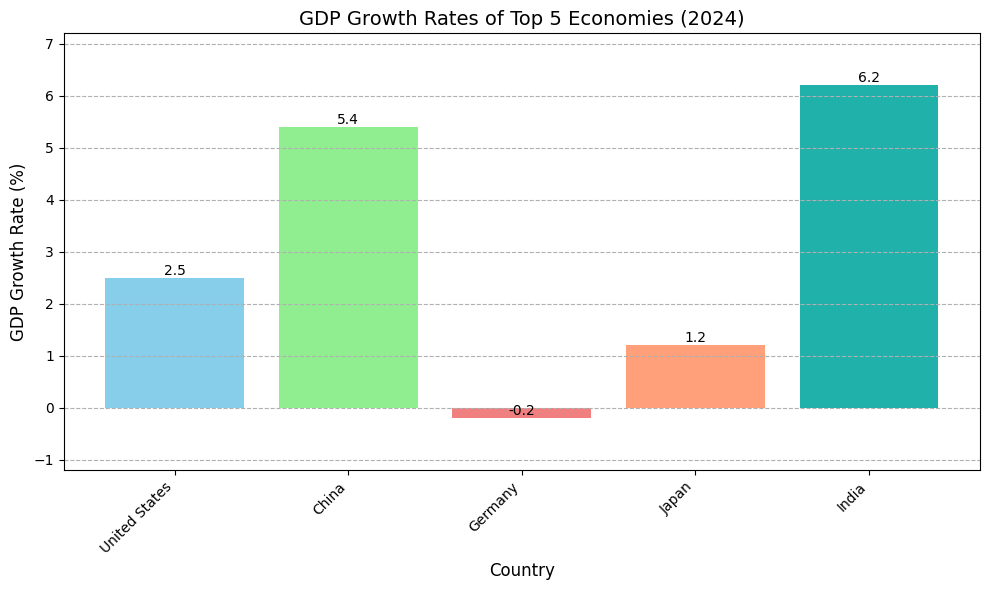

In [50]:
#Visualized the generated code

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.5, 5.4, -0.2, 1.2, 6.2]}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen']  # Define colors

bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Adding labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.ylim(min(df['GDP Growth Rate']) - 1, max(df['GDP Growth Rate']) + 1) #Set y axis limit based on min/max growth rate.

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis='y', linestyle='--')  # Add a grid for better readability

# Show plot
plt.show()

# Multimodal Search Example
## 7. Combining Search with Multimodal Capabilities


--- 7. Multimodal Search Exploration ---
# Gemini 2.0 can combine search with analysis of uploaded images

In this section, you'll upload an image and Gemini will:
1. Analyze the visual content to identify what's in the image
2. Use Google Search to find accurate, detailed information about the subject
3. Allow you to ask follow-up questions in the same conversation context

This demonstrates how Gemini combines visual understanding with search capabilities.

📸 Let's try this out!
Please upload an image (landmark, artwork, product, etc.)


Saving SAP_2011_logo.svg.png to SAP_2011_logo.svg (1).png
Uploaded image:


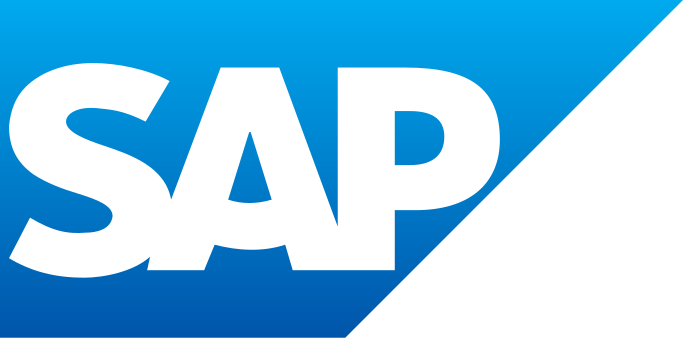


🔍 Analyzing image...


Main Subject: SAP logo

Description: The image shows the SAP logo, which features the white letters "SAP" on a blue background. A portion of the background is black and diagonally separated from the blue part.


🔍 Searching for detailed information...


The SAP logo has a rich history that dates back to the company's founding in 1972. Here is a breakdown of its evolution and some interesting facts:

**History and Evolution:**

*   **1972:** The very first SAP logo was created by Peter Leyh, one of the five co-founding engineers, at a kitchen table. This initial design featured the white "SAP" name inside a black square. It also included a separate triangle next to it, and the background of both shapes had blue and white stripes, similar to the IBM logo of the time, as stripes were associated with computers.
*   **1995:** The striped background was replaced with solid dark blue shapes, making the white letters stand out more clearly.
*   **1999:** A subtle change was made to the typeface of the "A," curving the horizontal bar upwards to resemble a "friendly grin" and symbolize the company's customer-friendly approach. The letters were also stretched vertically to fill more of the space.
*   **2000:** The separate square and triangle shapes were combined into a single geometric figure resembling a trapezoid. This change aimed to make the logo appear more professional and robust, and allowed the "SAP" inscription to be significantly larger.
*   **2011:** The trapezoid shape remained, but the dark blue color was updated to a lighter blue with a gradient, which is the version largely seen today.
*   **2014:** SAP briefly experimented with a radical change, eliminating the blue trapezoid and making the logo a plain gold wordmark (or white letters on a gold background). This was intended to convey optimism and friendliness. However, this change was not well-received by employees, customers, and shareholders, leading the company to quickly revert to the blue gradient design from 2011.

**Meaning and Symbolism:**

*   **SAP Name:** The initialism "SAP" stands for "Systems, Applications, and Products in Data Processing." This originated from the German "Systemanalyse und Programmentwicklung" (System Analysis and Program Development).
*   **Geometric Shape:** The combination of a square (symbolizing stability) and a triangle (representing forward motion or the future) creates the distinctive shape in the logo.
*   **Blue Color:** The blue color, particularly the gradient in the current logo, is associated with innovation, reliability, and trust. While SAP experimented with gold, blue has been a consistent color throughout the logo's history.
*   **The "Smiling A":** The slightly curved horizontal line in the letter "A" is intended to symbolize SAP's friendly attitude towards its customers.

**Interesting Facts:**

*   The first logo was designed on a kitchen table by one of the founders.
*   Early SAP marketing used technical jargon, sometimes referred to as "SAPanese."
*   SAP is a large European software company that helps businesses run more efficiently.
*   The company was founded in 1972 by five former IBM employees who wanted to develop software for real-time data processing.
*   Their first major product was a financial accounting system called R/1.
*   The brief attempt to change the logo to gold in 2014 was quickly reversed due to negative feedback.
*   SAP has grown significantly since its founding, serving over 340,000 customers in more than 180 countries.
*   The SAP logo is considered the company's most recognizable brand asset.
*   In some contexts, like in South Africa, "SAP" can also stand for South African Police, which the company's founders did not anticipate.
*   SAP has acquired several companies, including SuccessFactors, Ariba, and Qualtrics, to expand its services.


📊 Search Results Used:



📝 You can now ask follow-up questions about the image!
Example follow-up questions:
- 'How does it compare to similar examples?'
- 'What are common misconceptions about it?'
- 'When was the last major renovation or change?'
Enter a follow-up question (or press Enter to skip): Why company named SAP?

🔍 Searching for answer to: 'Why company named SAP?'


The company name "SAP" is an initialism derived from its original German name: "Systemanalyse und Programmentwicklung". This translates to "System Analysis and Program Development" in English.

Later, the name evolved slightly in German to "Systeme, Anwendungen und Produkte in der Datenverarbeitung", which translates to "Systems, Applications, and Products in Data Processing". This is the meaning most commonly associated with the SAP acronym today, reflecting their focus on creating software systems and applications for businesses to manage their processes and data.

The founders, five former IBM employees, started the company in 1972 with the goal of developing standard software for business solutions using real-time data processing, moving away from older methods like punch cards. The name reflected their initial work in analyzing systems and developing programs for business processes.


📊 Search Results Used:


In [51]:
print("\n--- 7. Multimodal Search Exploration ---")
print("# Gemini 2.0 can combine search with analysis of uploaded images")

from google.genai.types import HttpOptions, Part
from IPython.display import display, Image
from google.colab import files
import base64
import io

def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return image_file.read()

def upload_and_analyze_image():
    """Upload an image and analyze it with Gemini + Search"""
    print("Please upload an image (landmark, artwork, product, etc.)")
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded. Skipping image analysis.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Display the uploaded image
    print("Uploaded image:")
    display(Image(filename=image_path))

    # Encode the image to base64
    image_bytes = encode_image(image_path)

    # Create a new multimodal message with the image
    multimodal_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # First prompt to identify the image
    identification_prompt = f"""

    What is shown in this image? Please identify the main subject and provide a brief description in format below: \n
    Main Subject: subject \n
    Description: description \n
    """

    print("\n🔍 Analyzing image...")

    multimodal_chat.send_message([Part.from_bytes(data=image_bytes, mime_type="image/jpeg")])
    identification_response = multimodal_chat.send_message(identification_prompt)
    show_parts(identification_response)

    # Second prompt to get more detailed information with search
    detail_prompt = "Please search for more detailed information about this subject, including when it was created/built, its history, and interesting facts."

    print("\n🔍 Searching for detailed information...")
    detail_response = multimodal_chat.send_message(detail_prompt)
    show_parts(detail_response)

    return multimodal_chat

# Explanation for workshop participants
print("\nIn this section, you'll upload an image and Gemini will:")
print("1. Analyze the visual content to identify what's in the image")
print("2. Use Google Search to find accurate, detailed information about the subject")
print("3. Allow you to ask follow-up questions in the same conversation context")
print("\nThis demonstrates how Gemini combines visual understanding with search capabilities.")

# Run the interactive image upload and analysis
print("\n📸 Let's try this out!")
multimodal_chat = upload_and_analyze_image()

# Provide instructions for follow-up questions
if multimodal_chat:
    print("\n📝 You can now ask follow-up questions about the image!")
    print("Example follow-up questions:")
    print("- 'How does it compare to similar examples?'")
    print("- 'What are common misconceptions about it?'")
    print("- 'When was the last major renovation or change?'")

    # Option to ask a follow-up question
    follow_up = input("Enter a follow-up question (or press Enter to skip): ")
    if follow_up:
        print(f"\n🔍 Searching for answer to: '{follow_up}'")
        follow_up_response = multimodal_chat.send_message(follow_up)
        show_parts(follow_up_response)

# Practical Applications

## 8. Practical Applications of Search-Enabled AI

In [58]:
print("\n--- 8. Practical Applications Workshop ---")
print("# Let's explore practical real-world applications of search-enabled AI")

# Create a chat for practical applications
practical_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

application_scenarios = [
    "Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.",
    "Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.",
    "Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.",
    "Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).",
    "Educational Tool: Create learning materials with current facts, figures, and examples."
]

for i, scenario in enumerate(application_scenarios):
    print(f"\n{i+1}. {scenario}")

# Example of market analysis application
q8 = "Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends."
print("\n📝 Market Analysis Example Query: '{}'".format(q8))
market_response = practical_chat.send_message(q8)
show_parts(market_response)


--- 8. Practical Applications Workshop ---
# Let's explore practical real-world applications of search-enabled AI

1. Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.

2. Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.

3. Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.

4. Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).

5. Educational Tool: Create learning materials with current facts, figures, and examples.

📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'


The European electric vehicle (EV) market is currently in a dynamic phase, characterized by significant overall growth in recent years, but also experiencing fluctuations, regional variations, and evolving trends as it matures. While long-term prospects remain strong, recent months have seen some deceleration compared to the explosive growth of previous years, influenced by factors like subsidy changes and economic pressures.

**Growth Trends:**

*   **Recent Sales Growth:** In 2023, new electric car registrations (including Battery Electric Vehicles - BEVs and Plug-in Hybrid Electric Vehicles - PHEVs) in Europe reached nearly 3.2 million, an increase of almost 20% compared to 2022. Within the EU, sales hit 2.4 million, showing similar growth rates. Global EV sales grew by 35% year-on-year in 2023.
*   **2024 Performance:** Early 2024 data indicated more modest growth. Q1 2024 saw a year-on-year growth rate of over 5% in Europe, slightly above overall car market growth, stabilizing the EV sales share. However, some forecasts anticipated a potential slight decrease in overall EV sales volume or market share for the full year 2024 compared to 2023, partly due to subsidy removals in key markets like Germany. More recent data from September 2024 showed a resurgence, with plug-in vehicle registrations increasing 6% year-over-year, led by a 14% growth in BEVs, despite an overall market decline. However, PHEV sales have struggled, decreasing 9% in September 2024. Data for the full year 2024 indicated BEV sales in Europe (EU, EFTA, UK) contracted slightly by 1.3% to just under 2 million units.
*   **Future Projections:** Projections for 2024 suggested sales could reach around 3.5 million units, reflecting modest growth of less than 10% year-over-year. Looking ahead to 2025, stricter CO2 regulations are expected to push manufacturers to sell more EVs, potentially leading to significant growth, with some predictions suggesting a 67% increase in European BEV sales. The forecast period of 2023-2030 anticipates a Compound Annual Growth Rate (CAGR) of 17.9% for the European EV market. The market is expected to reach USD 319 billion in 2025 and USD 636.57 billion by 2029.
*   **Regional Variations:** Growth is not uniform across Europe. Germany, a major market, saw a decline in its EV sales share in 2023 (from 30% to 25%) and a drop in BEV sales in early 2024 following the removal of subsidies. In contrast, countries like France, the UK, Belgium, the Netherlands, and Nordic nations continued to show strong EV uptake. The UK overtook Germany as Europe's largest BEV market by volume in 2024.
*   **Hybrid Growth:** Alongside BEVs, hybrid-electric vehicles (HEVs) have seen significant growth, securing a 34% market share in September 2024 and outselling petrol cars for the first time. For the full year 2024, HEVs commanded nearly 31% of the EU market.
*   **Other Segments:** The electric Light Commercial Vehicle (LCV) market grew considerably in 2023, with European sales increasing by 60% to 150,000 units. Electric truck sales also grew, surpassing electric bus sales for the first time in 2023, with Europe reaching over 10,000 electric truck sales.

**Market Share:**

*   **Overall Electrified Share:** In September 2024, plug-in vehicles (BEVs + PHEVs) reached a 26% market share in Europe. When combined with HEVs (34% share), electrified vehicles accounted for a significant 60% of all new passenger car sales that month.
*   **BEV Market Share:** BEVs alone represented 19% of the market in September 2024. For the full year 2023, BEVs accounted for 15% of new car registrations in the EU. Full year 2024 data shows the average BEV share across Europe was around 14-15.4%, slightly down from 2023. In the EU specifically, the 2024 BEV share was 13.6%. Early 2025 data (Jan-Feb) showed the EU BEV share increasing to 15.2%.
*   **PHEV Market Share:** PHEVs accounted for 8% of EU registrations in 2023. Their share fell slightly to 7% in Europe in 2024.
*   **Leading Countries (by EV Share):** Norway remains the leader with EV sales shares around 90-95%. Other countries with high EV penetration include Sweden (around 58-60%), Denmark (55%), Finland (50%), the Netherlands (around 30-48%), and Belgium (around 43%). France and the UK had shares around 25% in 2023.
*   **Leading Brands & Groups:** As of September 2024, Tesla was the leading EV brand in Europe with an 11.4% market share, followed by Volkswagen at 7%. Volkswagen Group maintained its dominant position among automotive groups with a 20.8% share, followed by Tesla (11.4%) and BMW Group (11.1%). For the full year 2024, Volkswagen Group remained the top BEV seller, though its market share dipped slightly to 21.5%.

**Major Players:**

*   **Key Manufacturers:** Dominant players include legacy automakers and pure EV companies.
    *   Tesla (Models Y and 3 are often top sellers)
    *   Volkswagen Group (Volkswagen, Audi, Skoda, Cupra, Porsche)
    *   BMW Group (BMW, Mini)
    *   Stellantis (Peugeot, Fiat, Opel/Vauxhall, Jeep, etc.)
    *   Renault Group (Renault, Dacia, Alpine, Nissan partnership)
    *   Mercedes-Benz Group (Mercedes-Benz, Smart)
    *   Hyundai Motor Group (Hyundai, Kia)
    *   Volvo (including Polestar)
    *   Ford
    *   Toyota
*   **Emerging Players:** Chinese manufacturers like BYD are increasingly active and competitive in the European market. MG (owned by SAIC) has also seen success.
*   **Top Selling Models (Examples):** Recent top performers include the Tesla Model Y (consistently a leader), Tesla Model 3, Skoda Enyaq, Audi Q4 e-tron, and Volvo EX30.

**Current State Summary:**

The European EV market remains the second largest globally after China, accounting for about 25% of global EV sales in 2023. While growth has moderated from the peaks seen in 2020-2022, the transition is ongoing. Factors like government policies (including subsidy changes and upcoming CO2 targets), the expansion of charging infrastructure (over 630,000 public chargers in 2023), increasing model availability (590 models in 2023), and the introduction of more affordable EVs are shaping the market's trajectory. Challenges include economic pressures, the impact of subsidy withdrawals in some nations, and the need for continued infrastructure development. The market saw some stagnation or slight decline in BEV share in 2024 but is expected to accelerate again, driven partly by regulations taking effect in 2025.


📊 Search Results Used:


# Advanced Search Applications & Complicated Workflow


In [59]:
# @title ## 9a. Multi-stage Research Workflow with Progressive Refinement
# This advanced workflow demonstrates a structured research process that builds insights progressively

print("\n--- 9a. Multi-stage Research Workflow ---")
print("# This workflow demonstrates how to conduct in-depth research through multiple progressive stages")

def multi_stage_research(research_topic):
    """
    Conduct a multi-stage research process with progressive refinement

    Args:
        research_topic (str): The main research topic or question

    Returns:
        List of responses from each stage
    """
    # Create a new chat with search
    research_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

    # Store responses for visualization
    responses = []

    # Stage 1: Initial broad exploration
    print(f"\n📊 Stage 1: Initial exploration of '{research_topic}'")
    stage1_prompt = f"""
    I'm conducting research on '{research_topic}'.
    First, provide a broad overview of this topic covering:
    1. Main concepts and terminology
    2. Current state of development
    3. Key players or contributors
    4. Recent major developments

    After providing this overview, identify 3-5 specific subtopics that would be most
    interesting for further in-depth exploration.
    """

    stage1_response = research_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Extract subtopics for deeper investigation
    print(f"\n📊 Stage 2: Identifying key subtopics for deeper investigation")
    stage2_prompt = """
    Based on your previous response, extract exactly 3 subtopics that would be most valuable
    to explore further. For each subtopic:
    1. Clearly name the subtopic
    2. Explain why it's particularly significant
    3. Identify specific aspects that need deeper research

    Present these in a clear, structured format.
    """

    stage2_response = research_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: Deep dive into first subtopic
    print(f"\n📊 Stage 3: Deep dive into first subtopic")
    stage3_prompt = """
    Let's focus on the first subtopic you identified. Please conduct a comprehensive
    deep dive into this specific area. Your analysis should include:

    1. Latest research findings or developments
    2. Key challenges or controversies
    3. Notable innovations or breakthroughs
    4. Future directions and potential impacts
    5. Leading experts, organizations, or companies

    Support your analysis with specific examples, data points, and citations
    from your search results.
    """

    stage3_response = research_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Synthesis and insights
    print(f"\n📊 Stage 4: Synthesizing insights and recommendations")
    stage4_prompt = """
    Based on all the research we've conducted so far, please:

    1. Synthesize the key findings into 3-5 major insights
    2. Identify emerging trends or patterns across the research
    3. Note any gaps or contradictions in the current knowledge
    4. Provide recommendations for practical applications of this knowledge
    5. Suggest directions for future research

    Structure this as an executive brief that could inform strategic decision-making.
    """

    stage4_response = research_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the research stages
    # print("\n📊 Research Stage Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the multi-stage research on a complex topic
research_topic = "Quantum machine learning for drug discovery"
research_results = multi_stage_research(research_topic)

print("\n# This advanced workflow demonstrates how to break down complex research questions")
print("# into a structured process that builds deeper insights at each stage.")
print("# Note how the search tool is used differently at each stage of the research process.")


--- 9a. Multi-stage Research Workflow ---
# This workflow demonstrates how to conduct in-depth research through multiple progressive stages

📊 Stage 1: Initial exploration of 'Quantum machine learning for drug discovery'


## Quantum Machine Learning (QML) for Drug Discovery: An Overview

Quantum Machine Learning (QML) is an emerging field that combines quantum computing principles with machine learning algorithms. Its potential lies in leveraging quantum phenomena like superposition and entanglement to process information in ways fundamentally different from classical computers, potentially offering significant speedups and enhanced capabilities for complex tasks inherent in drug discovery.

### 1. Main Concepts and Terminology

*   **Quantum Computing (QC):** A type of computation that uses quantum mechanical phenomena, such as superposition and entanglement, to perform operations on data. Unlike classical bits (0 or 1), quantum bits (qubits) can exist in multiple states simultaneously (superposition). Entanglement links qubits so their fates are intertwined, regardless of distance.
*   **Quantum Machine Learning (QML):** An interdisciplinary field aiming to develop quantum algorithms to perform machine learning tasks more efficiently or effectively than classical algorithms. This involves translating classical ML algorithms into quantum circuits or developing entirely new quantum approaches. It also includes using classical ML to analyze data from quantum systems (CQ - Classical Processing, Quantum Data) and using quantum processing for classical data (QC - Quantum Processing, Classical Data), which is a major area of current development.
*   **Hybrid Quantum-Classical Approaches:** Given the limitations of current quantum hardware (e.g., noise, limited qubits), many current approaches involve using both quantum and classical computers. Variational algorithms, like the Variational Quantum Eigensolver (VQE) and Quantum Approximate Optimization Algorithm (QAOA), use a quantum computer for specific tasks (like calculating energy) while a classical computer optimizes parameters.
*   **Applications in Drug Discovery:** QML aims to accelerate various stages:
    *   **Molecular Simulation:** Accurately modeling molecular interactions and properties (e.g., binding affinity, stability, toxicity). QC can handle the quantum mechanical nature of these interactions more directly than classical methods.
    *   **Virtual Screening:** Searching vast libraries of chemical compounds much faster to identify potential drug candidates. Quantum algorithms like Grover's algorithm could offer exponential speedups for searching.
    *   **Property Prediction:** Using QML models (like Quantum Neural Networks - QNNs) to predict pharmacokinetic properties (ADMET - absorption, distribution, metabolism, excretion, toxicity) or other molecular properties.
    *   **Generative Models:** Employing techniques like Quantum Generative Adversarial Networks (QGANs) to design novel drug candidates *de novo*.
    *   **Optimization:** Optimizing molecular structures for desired properties like efficacy and safety.

### 2. Current State of Development

*   **Nascent Stage:** QML for drug discovery is still in its early stages, primarily focused on research and development. Practical applications are limited by current quantum hardware.
*   **Hardware Limitations:** Current quantum computers ("Noisy Intermediate-Scale Quantum" or NISQ devices) have a limited number of qubits and are susceptible to noise and errors, which affects calculation accuracy. Building stable, error-corrected quantum hardware is a major challenge.
*   **Algorithm Development:** Researchers are actively developing and testing QML algorithms (e.g., QNNs, QGANs, QSVMs, VQE) specifically for drug discovery tasks. Translating classical ML algorithms and creating new quantum ones suitable for noisy hardware is ongoing.
*   **Hybrid Focus:** Due to hardware limits, hybrid quantum-classical approaches are currently the most practical and recommended strategy. GPU-accelerated simulation of quantum algorithms is also crucial for research and development.
*   **Proof-of-Concept:** Studies are demonstrating the potential of QML, often showing competitive results with classical ML on specific, often smaller-scale, problems. Some work shows potential advantages in generalization, especially with limited datasets.
*   **Data Challenges:** Applying QML effectively requires handling large datasets typical in drug discovery, which poses challenges for current quantum systems, including data encoding and compression.

### 3. Key Players or Contributors

*   **Tech Companies:** Major players in quantum computing hardware and software are involved, including IBM, Google, Microsoft, Intel, NVIDIA, D-Wave Systems, Rigetti Computing, Xanadu Quantum Technologies, Atos SE, Fujitsu Limited, and Quantum Brilliance Pty Ltd. NVIDIA, for instance, provides platforms like CUDA-Q for simulating QML workloads. SpinQ offers superconducting quantum computers.
*   **Pharmaceutical & Biotech Companies:** Pharma giants and biotech firms are increasingly investing in and exploring QML, often through collaborations. Examples include Moderna, Merck KGaA, Pfizer, Janssen, Boehringer Ingelheim, Takeda, Bristol Myers Squibb, AstraZeneca, and Illumina.
*   **Specialized Startups:** Companies focus specifically on applying AI and quantum computing to drug discovery, such as Exscientia, BenevolentAI, Recursion, Insilico Medicine, Schrödinger, Atomwise Inc., Valo Health, CytoReason, AbCellera, 1QB Information Technologies, Inc., Qubit Pharmaceuticals, Kuano Ltd, XtalPi, Reverie Labs, and PathAI.
*   **Research Institutions & Academia:** Universities and research centers are driving fundamental research and algorithm development (e.g., Yale University, University of Warwick, Technical University of Berlin, University of Luxembourg, NC State University). Initiatives like India's National Quantum Mission also support R&D.
*   **Collaborations:** Interdisciplinary collaboration between quantum experts, computer scientists, chemists, biologists, and pharmaceutical researchers is crucial and increasingly common. For example, Pasqal and Qubit Pharmaceuticals collaborated on a hybrid approach for protein hydration analysis. NVIDIA, Moderna, and Yale jointly published research on QML for predicting molecular properties.

### 4. Recent Major Developments

*   **Algorithm Application:** Researchers are applying various QML algorithms like Quantum Neural Networks (QNNs), Quantum Generative Adversarial Networks (QGANs), Quantum Support Vector Machines (QSVMs), and Variational Quantum Eigensolvers (VQE) to specific drug discovery tasks like molecular property prediction, molecular generation, and binding energy calculations.
*   **Hybrid Models:** Significant focus is on developing and refining hybrid quantum-classical algorithms better suited for NISQ hardware. Studies are comparing the performance of QML, classical ML, and hybrid approaches.
*   **Hardware Simulation & Platforms:** Advances in classical simulation of quantum systems, often using GPUs (e.g., NVIDIA's CUDA-Q platform), are enabling larger-scale testing and development of QML algorithms before robust quantum hardware is available.
*   **Integration with AI:** There's a growing trend of integrating QML/QC with established AI/ML techniques to enhance predictions and accelerate the drug development process.
*   **Application Expansion:** QML is being explored for more complex biological molecules, including predicting mRNA structures and antibody-antigen interactions. Federated Quantum Machine Learning (FQML) is being investigated to enable collaborative research while preserving data privacy.
*   **Industry Investment & Collaboration:** Increased investment from pharmaceutical companies and strategic partnerships between tech firms, pharma companies, and research institutions are accelerating progress. Recent acquisitions, like BioNTech acquiring InstaDeep, highlight the growing importance of AI (and potentially quantum) capabilities in drug discovery.

## Suggested Subtopics for Further Exploration

Based on the overview, here are 3-5 specific subtopics for deeper research:

1.  **Hybrid Quantum-Classical Algorithms for Molecular Property Prediction:** Investigate specific hybrid algorithms (like VQE variants or quantum-enhanced neural networks) being used to predict crucial drug properties (e.g., binding affinity, ADMET). Compare their performance, scalability, and practical limitations against purely classical state-of-the-art methods on benchmark datasets. Explore techniques for integrating classical data efficiently into quantum circuits.
2.  **Quantum Generative Models (QGANs, QVAEs) for *De Novo* Drug Design:** Explore the application of quantum generative models for creating novel molecular structures with desired properties. What are the theoretical advantages (e.g., exploring larger chemical spaces, generating more diverse structures)? What challenges exist in training these models on current hardware, and how do they compare to classical generative models like GANs or VAEs in drug discovery?
3.  **Error Mitigation and Hardware Constraints in QML for Drug Discovery:** Delve into the specific challenges posed by NISQ hardware (noise, limited qubits, decoherence) for drug discovery applications. What error mitigation techniques are being developed and applied in QML algorithms? How do researchers compress complex molecular data (like large descriptors) to fit within current qubit limitations, and what is the impact on model accuracy?
4.  **Quantum Algorithms for Molecular Docking and Binding Energy Calculation:** Focus on how quantum algorithms (e.g., VQE, Quantum Phase Estimation) are applied to simulate the intricate process of drug-target binding. How does the accuracy of quantum simulations compare to classical methods like DFT or force fields, especially concerning factors like protein hydration and flexibility? What are the computational requirements and potential speedups?
5.  **Benchmarking and Demonstrating Quantum Advantage in Drug Discovery Tasks:** Analyze the current evidence for "quantum advantage" (where a quantum computer significantly outperforms the best classical computer for a specific task) in drug discovery. Which specific problems (e.g., specific molecular simulations, types of database searches, optimization tasks) are considered the most promising candidates for demonstrating near-term quantum advantage? What metrics and datasets are used for comparison?


📊 Search Results Used:



📊 Stage 2: Identifying key subtopics for deeper investigation


Okay, here are three subtopics from the previous list, selected for their high potential value for further exploration in Quantum Machine Learning for Drug Discovery:

---

### Subtopic 1: Hybrid Quantum-Classical Algorithms for Molecular Property Prediction

*   **Significance:** This area is highly significant because it represents the most practical and actively researched approach for applying QML in the near term, given the limitations of current Noisy Intermediate-Scale Quantum (NISQ) hardware. Hybrid models leverage the strengths of both quantum (for specific complex calculations) and classical (for optimization and control) computing, offering a feasible pathway to potential quantum advantage without requiring fully fault-tolerant quantum computers. Success here could lead to faster and more accurate predictions of crucial drug properties like binding affinity or ADMET profiles.
*   **Aspects Needing Deeper Research:**
    *   **Algorithm Efficiency:** Rigorous benchmarking of different hybrid algorithms (e.g., specific VQE ansätze, Quantum Circuit Learning models) against state-of-the-art classical ML methods on relevant drug discovery datasets.
    *   **Scalability:** How do these hybrid approaches scale with increasing molecular size and dataset complexity? What are the bottlenecks (quantum or classical)?
    *   **Data Encoding:** Investigating optimal methods for encoding complex molecular features into quantum states suitable for NISQ devices, balancing information content with qubit and coherence time limitations.
    *   **Integration with Classical ML:** Exploring architectural designs that best integrate quantum components into larger classical ML pipelines for property prediction.

---

### Subtopic 2: Quantum Generative Models (QGANs, QVAEs) for *De Novo* Drug Design

*   **Significance:** This subtopic explores a potentially transformative application of QML: creating entirely new drug candidates rather than just screening existing ones. Classical generative models are already impactful, but quantum versions might offer advantages in exploring vast chemical spaces more effectively or generating molecules with higher diversity and desired quantum mechanical properties. This addresses a core challenge in drug discovery – finding novel, effective chemical matter.
*   **Aspects Needing Deeper Research:**
    *   **Expressivity and Capacity:** Can quantum generative models represent complex molecular distributions more effectively than classical counterparts? How does their capacity to generate diverse and valid molecular structures compare?
    *   **Trainability on NISQ Hardware:** Developing techniques to train QGANs or Quantum Variational Autoencoders (QVAEs) effectively despite noise and limited qubit counts. Addressing challenges like barren plateaus in the training landscape.
    *   **Property Conditioning:** How can these quantum models be effectively guided to generate molecules with specific desired properties (e.g., high binding affinity, good solubility)?
    *   **Benchmarking:** Establishing clear benchmarks and metrics to compare the quality, novelty, and diversity of molecules generated by QML models versus classical generative approaches.

---

### Subtopic 3: Error Mitigation and Hardware Constraints in QML for Drug Discovery

*   **Significance:** This is fundamentally important because the success of *any* QML application in drug discovery hinges on overcoming the limitations of current and near-term quantum hardware. Noise, limited qubit counts, and short coherence times currently restrict the size and complexity of problems that can be tackled. Developing effective error mitigation strategies and hardware-aware algorithms is crucial for achieving reliable and meaningful results from quantum computations in this demanding field.
*   **Aspects Needing Deeper Research:**
    *   **Impact of Noise:** Quantifying the specific impact of different types of hardware noise on the accuracy of various QML algorithms used in drug discovery tasks (e.g., VQE for energy calculations, QNNs for predictions).
    *   **Effectiveness of Mitigation Techniques:** Evaluating the performance and overhead of various error mitigation techniques (e.g., zero-noise extrapolation, probabilistic error cancellation, dynamical decoupling) specifically within drug discovery workflows.
    *   **Resource Estimation:** Developing accurate methods to estimate the quantum hardware resources (qubit count, coherence time, gate fidelity) required for specific drug discovery problems to achieve quantum advantage over classical methods.
    *   **Co-design:** Exploring hardware-software co-design approaches where QML algorithms are specifically tailored to the constraints and error characteristics of particular quantum hardware platforms.


📊 Stage 3: Deep dive into first subtopic


## Deep Dive: Hybrid Quantum-Classical Algorithms for Molecular Property Prediction

Hybrid quantum-classical algorithms represent a crucial near-term strategy for leveraging quantum computation in drug discovery, specifically for predicting molecular properties. These algorithms combine the strengths of classical computers (handling large datasets, optimization routines) with the potential power of quantum processors (simulating quantum systems, exploring complex correlations). They typically involve a quantum circuit with tunable parameters (an "ansatz") whose output is measured to compute an objective function (e.g., molecular energy, property value); a classical optimizer then updates these parameters iteratively. Variational Quantum Eigensolver (VQE) is a prominent example often used for ground state energy calculations, which forms the basis for predicting many other properties.

### 1. Latest Research Findings or Developments

*   **Algorithm Application & Benchmarking:** Researchers are actively applying and benchmarking various hybrid models, such as VQE, Quantum Neural Networks (QNNs), and Quantum Support Vector Machines (QSVMs with quantum kernels), for predicting properties like molecular energy, binding affinity, ADMET (Absorption, Distribution, Metabolism, Excretion, Toxicity) properties, and more. Studies compare these hybrid models against purely classical ML algorithms (like CNNs, GNNs, XGBoost) on standard datasets (e.g., QM9).
*   **Enhanced Performance Claims:** Several studies report that hybrid quantum-classical models can outperform their purely classical counterparts, sometimes significantly. For instance, one study using a hybrid quantum neural network for drug response prediction reported a 15% improvement in predicting IC50 values over its classical analog. Another showed hybrid models achieved better accuracy than classical deep learning for drug target prediction, converging faster. A QML framework using a quantum kernel with a classical SVM achieved high AUC ROC scores (0.80-0.95) for predicting ADMET properties.
*   **Specific Algorithm Developments:**
    *   **Hybrid QNNs:** Integrating variational quantum circuits (regressors or layers) into classical neural networks (like MLPs or GNNs) shows promise. Studies have explored predicting physicochemical properties of CO2-capturing amines using Hybrid Quantum Neural Networks (HQNNs), demonstrating improved accuracy and robustness even under simulated hardware noise. Unique hybrid quantum classical convoluted graph neural networks (HyQCGNN) have been developed and shown competitive performance in predicting formation energies.
    *   **VQE Applications:** VQE is used beyond ground state energy to compute potential energy surfaces (PES) by running calculations at various molecular geometries. These PES can then be used to derive thermodynamic properties. VQE has been successfully applied to predict chemically accurate bond dissociation curves for molecules like LiH, NaH, and KH, although currently limited to relatively small systems. It's also being adapted to calculate molecular response properties (like polarizability).
*   **Simulation Emphasis:** Due to NISQ hardware limitations, much current research relies heavily on classical simulation of quantum circuits, often accelerated by GPUs using platforms like NVIDIA's CUDA-Q. This allows for testing larger models and exploring different architectures before running on actual quantum hardware.

### 2. Key Challenges or Controversies

*   **NISQ Hardware Limitations:** The primary challenge remains the limitations of current Noisy Intermediate-Scale Quantum (NISQ) devices. Noise, decoherence, limited qubit counts, and short coherence times severely restrict the size and complexity of molecules and properties that can be accurately simulated or predicted. Error mitigation techniques are essential but add overhead.
*   **Scalability:** While algorithms like VQE theoretically scale favorably (linearly with qubit number for certain aspects), the practical scaling with molecular size, basis set size, and required accuracy is challenging. The classical optimization part of hybrid algorithms can also become a bottleneck, especially in noisy environments or complex energy landscapes (e.g., encountering "barren plateaus" where gradients vanish).
*   **Data Encoding:** Efficiently encoding complex classical data (like molecular structures or features) into quantum states (qubits) is non-trivial. The choice of encoding method significantly impacts performance and resource requirements. Finding encodings that capture relevant chemical information without requiring excessive qubits or deep circuits is an active research area.
*   **Benchmarking and Quantum Advantage:** Demonstrating a clear "quantum advantage" – where a hybrid quantum-classical approach definitively and practically outperforms the best classical algorithms for a meaningful molecular property prediction task – remains an elusive goal. Many promising results are on small systems or specific datasets, and rigorous comparison against highly optimized classical methods is needed. Some researchers question whether near-term quantum advantage is feasible for ML tasks compared to quantum simulation tasks.
*   **Integration Complexity:** Seamlessly integrating quantum components into existing classical drug discovery pipelines requires specialized expertise and robust software frameworks capable of managing hybrid workflows.

### 3. Notable Innovations or Breakthroughs

*   **Hybrid Model Architectures:** The development of novel hybrid architectures, such as integrating quantum layers into Graph Neural Networks (HyQCGNN) or Convolutional Neural Networks, represents significant innovation. Combining quantum kernels with classical SVMs is another successful approach.
*   **Targeted Applications:** Applying hybrid models to predict specific, challenging properties shows progress. Examples include predicting ADMET properties, designing molecules targeting difficult proteins like KRAS, predicting drug response for personalized medicine, and calculating molecular response properties beyond simple energies.
*   **Hardware-Aware Algorithms & Platforms:** Innovations include developing algorithms tailored to specific hardware capabilities and limitations. Platforms like NVIDIA's CUDA-Q facilitate large-scale simulation and development of hybrid QML workloads, enabling research that requires interweaving classical and quantum resources. Cloud platforms (IBM Quantum, Azure Quantum, etc.) provide access to both simulators and real quantum hardware for experimentation.
*   **Error Mitigation Integration:** Progress is being made in integrating error mitigation techniques directly into hybrid workflows to improve the reliability of results obtained from noisy quantum hardware.
*   **Proof-of-Concept Successes:** While large-scale advantage is pending, successful demonstrations on small molecules (like LiH) or specific datasets serve as important proofs-of-concept, validating the potential of the hybrid approach. A hybrid quantum-classical model recently designed novel KRAS inhibitors that were experimentally validated.

### 4. Future Directions and Potential Impacts

*   **Improved Algorithms & Hardware:** Continued development of more efficient, noise-resilient variational algorithms and improved quantum hardware (more qubits, lower error rates, longer coherence times) are critical. Fault-tolerant quantum computers, when available, would significantly expand capabilities but are still a longer-term prospect.
*   **Focus on Quantum Advantage:** The field will increasingly focus on identifying specific molecular property prediction tasks where hybrid QML can demonstrate a tangible advantage over classical methods, moving beyond theoretical speedups to practical benefits.
*   **Integration with Classical AI & HPC:** Deeper integration of hybrid QML methods with established classical AI/ML and High-Performance Computing (HPC) workflows is expected, creating more powerful and efficient predictive tools.
*   **Larger & More Complex Systems:** As hardware and algorithms improve, research will tackle larger, more complex molecules relevant to real-world drug discovery, including biologics like proteins and mRNA.
*   **Standardized Benchmarks:** Development of standardized benchmarks and datasets specifically for QML in drug discovery is needed for fair comparison and tracking progress.
*   **Potential Impact:** Successful hybrid QML for molecular property prediction could significantly accelerate drug discovery by:
    *   Reducing the time and cost of identifying promising drug candidates.
    *   Improving the accuracy of predicting efficacy and safety (e.g., ADMET).
    *   Enabling the exploration of larger chemical spaces.
    *   Facilitating the design of personalized medicines by better predicting individual drug responses.
    *   Helping tackle previously "undruggable" targets.

### 5. Leading Experts, Organizations, or Companies

*   **Tech Companies (Hardware & Platforms):** IBM Quantum, Google Quantum AI, Microsoft Quantum (Azure Quantum), NVIDIA (CUDA-Q platform), IonQ, Quantinuum, Rigetti, Xanadu, IQM Quantum Computers, ORCA Computing, Atos.
*   **Specialized QML/Drug Discovery Software & Startups:** Qubit Pharmaceuticals, Aqemia, Kuano, Qunova Computing, QSimulate, SandboxAQ, Terra Quantum, Quantistry, PASQAL, Zapata Computing.
*   **Pharmaceutical & Biotech Companies:** Many large pharma companies are exploring or investing in QML through collaborations or internal teams, including Merck KGaA, Moderna, Novo Nordisk, Biogen, Sanofi, and others through initiatives like Q4Bio.
*   **Research Institutions & Academia:** Numerous universities and research centers are active, including collaborations like the Quantum Systems Accelerator (QSA), research groups at institutions like Yale University, University of Chicago (Gagliardi Group), NC State University, and researchers publishing actively in the field (as evidenced by papers on platforms like arXiv).
*   **Collaborations:** Cross-disciplinary partnerships are common and crucial, such as IBM's work with Cleveland Clinic, Merck with HQS Quantum Simulations, IQM with Quantistry, and NVIDIA with Moderna and Yale.


📊 Search Results Used:



📊 Stage 4: Synthesizing insights and recommendations


## Executive Brief: Quantum Machine Learning (QML) in Drug Discovery

**Date:** October 26, 2023

**Subject:** Strategic Overview of Quantum Machine Learning Applications and Potential in Drug Discovery

This brief synthesizes recent research on the intersection of quantum computing and machine learning for accelerating pharmaceutical R&D, providing insights for strategic decision-making.

**1. Major Insights**

*   **Hybrid Approach is Key (Near-Term):** Given current hardware limitations (NISQ era - Noisy Intermediate-Scale Quantum), hybrid quantum-classical algorithms are the most practical and actively pursued strategy. These leverage quantum processors for specific computational tasks while relying on classical computers for control, optimization, and data handling.
*   **Potential Demonstrated, Advantage Unproven:** QML techniques, particularly hybrid models (e.g., VQE, QNNs), show *potential* for enhancing molecular property prediction (like binding affinity, ADMET) and *de novo* design. Some studies report competitive or superior performance compared to classical methods on specific, often small-scale, problems. However, a definitive, practical "quantum advantage" over state-of-the-art classical algorithms for industry-relevant drug discovery tasks has not yet been demonstrated.
*   **Hardware & Error Mitigation are Critical Bottlenecks:** The primary barrier to wider application is the current state of quantum hardware – limited qubit counts, short coherence times, and significant noise levels. Progress is tightly coupled to advancements in hardware stability, scale, and the development of effective, low-overhead error mitigation techniques.
*   **Collaborative Ecosystem is Essential:** Advancements require deep collaboration between quantum hardware providers (e.g., IBM, Google, NVIDIA, IonQ), software/algorithm specialists (e.g., Qubit Pharmaceuticals, Zapata), pharmaceutical companies (e.g., Merck, Moderna), and academic researchers. Platforms facilitating simulation (like NVIDIA's CUDA-Q) and hybrid workflows are crucial enablers.

**2. Emerging Trends & Patterns**

*   **Shift Towards Application & Benchmarking:** Research is moving from theoretical exploration to applying specific QML algorithms (VQE, QNNs, QGANs, QSVMs) to concrete drug discovery problems and attempting to benchmark them against classical methods.
*   **Rise of Simulation Platforms:** Due to limited access and constraints of real quantum hardware, high-performance classical simulation of quantum circuits (often GPU-accelerated) is a dominant trend for algorithm development and testing.
*   **Increased Industry Investment & Partnerships:** Pharmaceutical companies are increasingly investing in QML exploration, often through strategic partnerships with quantum computing firms and startups, signaling recognition of its long-term potential.
*   **Integration, Not Replacement:** QML is increasingly viewed as a potential component to be integrated within broader AI/ML drug discovery pipelines, augmenting rather than replacing established classical techniques in the near term.

**3. Gaps or Contradictions**

*   **Quantum Advantage Gap:** The most significant gap is the lack of clear evidence demonstrating practical quantum advantage for real-world drug discovery challenges versus optimized classical methods. Reported successes are often on limited benchmarks.
*   **Scalability Uncertainty:** How current QML algorithms, particularly hybrid ones, will scale to handle the complexity of large molecules and datasets on future hardware remains uncertain. Theoretical scaling benefits may not translate directly into practical performance gains due to noise and optimization challenges.
*   **Lack of Standardized Benchmarks:** The field lacks widely accepted, standardized benchmarks specifically for QML in drug discovery, making rigorous comparison between different approaches difficult.
*   **Performance Claims vs. Hardware Reality:** There can be a perceived contradiction between optimistic performance claims in some QML research papers and the acknowledged severe limitations imposed by current NISQ hardware noise and scale.

**4. Recommendations for Practical Applications**

*   **Strategic Investment in Hybrid Capabilities:** Invest cautiously in building internal understanding or establishing partnerships focused on hybrid quantum-classical approaches. Prioritize developing expertise in data encoding for quantum systems and error mitigation awareness. Utilize simulation platforms extensively for de-risking and exploration.
*   **Target Niche, High-Impact Problems:** Focus initial QML efforts on specific problems where quantum mechanics are inherently dominant and classical methods face known limitations (e.g., accurate simulation of reaction mechanisms, specific protein-ligand interactions, certain electronic structure calculations).
*   **Leverage for Hypothesis Generation:** Explore QML, particularly generative models (QGANs), as tools to explore chemical space and generate novel molecular scaffolds or hypotheses, which can then be validated and optimized using mature classical techniques.
*   **Stay Engaged & Monitor Progress:** Actively monitor advancements in quantum hardware, algorithms, and error correction. Participate in industry consortia (e.g., Q4Bio) or collaborations to share knowledge, risk, and stay abreast of this rapidly evolving field.

**5. Future Research Directions**

*   **Fault-Tolerant Algorithm Development & Resource Estimation:** While exploiting NISQ, research must look ahead to develop algorithms suitable for future fault-tolerant quantum computers and provide realistic estimates of the quantum resources needed to achieve advantage in drug discovery.
*   **Establish Robust Benchmarks & Demonstrate Advantage:** Focus on creating standardized, industry-relevant benchmarks. Prioritize research aiming to rigorously demonstrate quantum advantage on specific, high-value drug discovery tasks.
*   **Advance Error Mitigation & Hardware Co-design:** Develop more sophisticated and efficient error mitigation techniques tailored for drug discovery computations. Explore co-designing algorithms specifically for the characteristics of available quantum hardware.
*   **Quantum Data Integration:** Investigate novel ways to efficiently represent and process complex chemical/biological data on quantum computers, potentially exploring the use of quantum sensors or simulations to generate data inherently suited for QML.


# This advanced workflow demonstrates how to break down complex research questions
# into a structured process that builds deeper insights at each stage.
# Note how the search tool is used differently at each stage of the research process.


In [82]:
# @title ## 9b. Competitive Intelligence Framework
#This workflow demonstrates how to use search for detailed competitive analysis

print("\n--- 9b. Competitive Intelligence Framework ---")
print("# Using Gemini's search capabilities to conduct structured competitive analysis")

def competitive_intelligence_analysis(company_name, industry=None):
    """
    Conduct a structured competitive intelligence analysis for a company

    Args:
        company_name (str): The target company to analyze
        industry (str): Optional industry context

    Returns:
        List of responses from the analysis
    """
    # Create a new chat with search
    competitive_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # Store responses
    responses = []

    # Stage 1: Company profile and market position
    print(f"\n📊 Stage 1: Company profile and market position for {company_name}")
    stage1_prompt = f"""
    Conduct a comprehensive analysis of {company_name}{' in the ' + industry + ' industry' if industry else ''}.

    Include:
    1. Brief company overview (history, size, key offerings)
    2. Current market position and market share if available
    3. Recent financial performance and growth trends
    4. Key executives and leadership changes
    5. Recent strategic moves (acquisitions, partnerships, new product launches)

    Focus on factual information from reliable sources. Include specific numbers
    and metrics wherever possible.
    """

    stage1_response = competitive_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Competitor identification and comparison
    print(f"\n📊 Stage 2: Competitor identification and analysis")
    stage2_prompt = f"""
    Identify the top 3-5 direct competitors of {company_name}.

    For each competitor:
    1. Provide a brief company overview
    2. Compare their market share and position to {company_name}
    3. Analyze their key differentiators and competitive advantages
    4. Describe their recent strategic moves
    5. Evaluate their strengths and weaknesses relative to {company_name}

    Present this in a structured comparative format.
    """

    stage2_response = competitive_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: SWOT analysis
    print(f"\n📊 Stage 3: SWOT analysis for {company_name}")
    stage3_prompt = f"""
    Based on the information gathered, conduct a detailed SWOT analysis for {company_name}:

    1. Strengths: Internal advantages and capabilities
    2. Weaknesses: Internal disadvantages or limitations
    3. Opportunities: External factors that could benefit the company
    4. Threats: External factors that could negatively impact the company

    For each category, provide 4-5 specific points with brief explanations supported by
    the information you've gathered.
    """

    stage3_response = competitive_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Strategic recommendations
    print(f"\n📊 Stage 4: Strategic recommendations")
    stage4_prompt = f"""
    Based on all the competitive intelligence gathered, provide strategic recommendations for {company_name}.

    Your recommendations should address:
    1. How to leverage identified strengths
    2. How to address or mitigate weaknesses
    3. How to capitalize on market opportunities
    4. How to defend against competitive threats
    5. Potential areas for innovation or market disruption

    Format these as actionable strategic recommendations that could be presented to executives.
    """

    stage4_response = competitive_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the analysis stages
    # print("\n📊 Competitive Analysis Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the competitive intelligence analysis on a real company
target_company = "Rivian"
industry = "Electric Vehicle Manufacturing"
competitive_results = competitive_intelligence_analysis(target_company, industry)

print("\n# This framework demonstrates how to use search capabilities for comprehensive competitive analysis")
print("# The structured approach ensures thorough coverage of all aspects of competitive intelligence")
print("# Notice how the search tool grounds the analysis in factual, up-to-date information")


--- 9b. Competitive Intelligence Framework ---
# Using Gemini's search capabilities to conduct structured competitive analysis

📊 Stage 1: Company profile and market position for Rivian


## Rivian in the Electric Vehicle Manufacturing Industry: A Comprehensive Analysis

Rivian Automotive, Inc. is an American electric vehicle (EV) manufacturer, automotive technology, and outdoor recreation company founded in 2009 by R.J. Scaringe. Initially focused on autonomous and electric vehicles under different names, the company settled on Rivian Automotive in 2011. Rivian is headquartered in Irvine, California, with its primary manufacturing facility located in Normal, Illinois, and other facilities in the U.S., Serbia, Britain, and Canada.

**1. Brief Company Overview (History, Size, Key Offerings)**

*   **History:** Founded in 2009, Rivian initially explored different vehicle concepts before focusing on electric adventure vehicles. The company received significant investments from major players like Amazon and Ford in its early years. Rivian went public in November 2021 through an IPO, raising $13.5 billion.
*   **Size:** As of December 2023, Rivian had 16,790 employees. The company is planning to build a second U.S. manufacturing facility in Georgia.
*   **Key Offerings:** Rivian produces an electric pickup truck (R1T), an electric sport utility vehicle (R1S), and an electric delivery van (EDV). These vehicles are built on a flexible "skateboard" platform. The EDV was initially exclusive to Amazon, a key investor, but sales were opened to other companies in November 2023 under the name ECV / Delivery.

**2. Current Market Position and Market Share**

Rivian is considered a relevant player in the electric vehicle sector, particularly targeting the electric truck and SUV segments. While still in the early growth stages, Rivian is carving out a niche despite competing with larger, established players like Tesla, Ford, and General Motors. As of 2024, Rivian held a 0.41% share of the U.S. EV market. Some analysts see Rivian, with its upcoming competitive R2 model and U.S. manufacturing base, as well-positioned to capture significant market share, potentially becoming an iconic American auto brand.

**3. Recent Financial Performance and Growth Trends**

Rivian's recent financial performance shows some improvements but also ongoing challenges. In the fourth quarter of 2024, Rivian reported a gross profit of $170 million, a significant improvement compared to a loss in the same period of the previous year. This was driven by improvements in variable costs, revenue per delivered unit, and fixed costs, as well as increased revenue from the sale of regulatory credits and software/services, and higher R1 average selling prices.

For the full calendar year 2024, Rivian produced 49,476 vehicles and delivered 51,579. Revenue for the last twelve months ending September 30, 2024, was $4.55 billion, compared to $4.43 billion in 2023. However, the company still reported a net loss of $744 million in Q4 2024, narrower than the $1.52 billion loss in Q4 2023. For the full year 2024, the net loss was $1.2 billion, down from $2.03 billion in 2023. Adjusted EBITDA loss for fiscal year 2024 was negative $2.69 billion.

Looking ahead to fiscal year 2025, Rivian projects a narrower adjusted EBITDA loss between $1.70 billion and $1.90 billion and expects to achieve a modest gross profit for the year. However, they anticipate lower vehicle deliveries, projecting between 46,000 and 51,000 units. Despite revenue growth, Rivian still faces challenges with low gross margins due to manufacturing costs and significant R&D expenditures.

**4. Key Executives and Leadership Changes**

R.J. Scaringe is the Founder and CEO of Rivian. Recent months have seen several executive changes at the company. In November 2023, CEO R.J. Scaringe assumed direct responsibility for all product functions, including Software, Autonomy, Design, Electrical, Propulsion, and Vehicle, taking on a more centralized product leadership role. As part of this reshuffling, Chief Product Officer Nick Kalayjian moved to the role of Executive Vice President of Vehicle Engineering and Propulsion to focus on the next-generation "Peregrine" platform before transitioning to an advisory role. Richard Farquhar, formerly VP of propulsion, became the Senior Vice President of R&D.

More recently, Kjell Gruner, Rivian's chief commercial officer and president of business growth, resigned in July 2024, with Dagan Mishoulam being promoted to SVP of Commercial to assume many of his responsibilities. Jeffrey Baker, the chief accounting officer, also resigned in July 2024, with CFO Claire McDonough taking over as interim principal accounting officer. In May 2024, Rivian announced Javier Varela, former Volvo Cars COO, would become their new COO, succeeding Frank Klein. Jennifer Prenner was also hired earlier in 2024 to lead marketing efforts.

**5. Recent Strategic Moves (Acquisitions, Partnerships, New Product Launches)**

Rivian has made several significant strategic moves recently:

*   **Volkswagen Group Partnership:** In June 2024, Rivian announced a major joint venture with Volkswagen Group with a total deal size of up to $5.8 billion, including a $1 billion initial investment from Volkswagen and an additional $4 billion planned through 2026. This partnership aims to collaborate on next-generation electrical architecture and software technology for future EVs from both companies, starting with the Rivian R2. The joint venture was closed in the fourth quarter of 2024.
*   **Department of Energy Loan:** Rivian closed a loan agreement with the U.S. Department of Energy's Loan Programs Office for up to $6.6 billion. This loan is intended to support the construction of Rivian's new manufacturing facility in Georgia.
*   **New Product Launches/Development:** Rivian is accelerating the development of its upcoming R2 vehicles, which will be based on the new "Peregrine" architecture. The R2 lineup is expected to be more affordable and compete with vehicles like the Tesla Model Y. The R2 SUV is expected to be unveiled in early 2024 and launched in the first half of 2026. Rivian also has plans for an R3 vehicle.
*   **Opening EDV Sales:** While initially exclusive to Amazon, Rivian began selling its electric delivery vans (EDV) to other commercial fleet buyers in November 2023, offering them in different sizes (500, 700, and 900 cubic feet). Deliveries to new fleet customers began in April 2025.
*   **Micromobility Spin-off:** Rivian spun off its micromobility business into a new independent company called Also, Inc., which will focus on small, lightweight electric vehicles. Rivian retains a significant minority stake in Also.
*   **Partnerships for Customization:** Rivian has collaborated with companies like Xpel to expand customization options for its vehicles, offering paint and window protection products.

Rivian continues to navigate production challenges and supply chain issues, which are common for startups in the automotive industry. However, its strategic partnerships, particularly with Amazon and Volkswagen, and focus on differentiating products like electric trucks and SUVs are seen as key strengths.


📊 Search Results Used:



📊 Stage 2: Competitor identification and analysis


Rivian operates in a competitive electric vehicle market, facing established automakers and other EV startups. Based on its positioning in the electric truck and SUV segments, its top direct competitors include Tesla, Ford, and General Motors.

Here's a structured comparison of Rivian and these key competitors:

**1. Tesla**

*   **Brief Company Overview:** Tesla, Inc. is an American multinational automotive and clean energy company founded in 2003. It designs, manufactures, and sells battery electric vehicles, energy storage systems, and solar products. Tesla is headquartered in Austin, Texas. Its current vehicle lineup includes the Model S, Model X, Model 3, Model Y, Semi, and Cybertruck.
*   **Market Share and Position Comparison:** Tesla is the dominant player in the EV market, holding an estimated 18% share of the battery electric vehicle market as of early 2025. While Rivian has a much smaller share (0.41% in the U.S. EV market as of 2024), it competes with Tesla's Cybertruck in the electric truck segment and the Model X/Y in the electric SUV/crossover space. Tesla is well-established and profitable, whereas Rivian is still in its early stages, focused on increasing production and achieving profitability.
*   **Key Differentiators and Competitive Advantages:** Tesla's competitive advantages include its superior battery technology, extensive Supercharger network, strong brand recognition, innovative software capabilities (including over-the-air updates), and vertical integration in its production processes. They are also a leader in autonomous driving technology with their Autopilot system.
*   **Recent Strategic Moves:** Tesla has recently adjusted production focus, scaling back Cybertruck output to prioritize the higher-volume Model Y. They also introduced a cheaper rear-wheel-drive Cybertruck variant. Tesla is expanding globally, with recent market entries like Saudi Arabia. They are also focused on developing a lower-cost vehicle platform and their robotaxi/Cybercab. However, there have been reports of scrapping plans for a long-awaited affordable model (often referred to as the Model 2) to focus on the robotaxi.
*   **Strengths and Weaknesses Relative to Rivian:**
    *   **Strengths:** Much larger production volume, established global sales and service network, strong profitability (unlike Rivian), recognized brand, mature charging infrastructure (Supercharger network), more advanced driver-assistance systems.
    *   **Weaknesses:** Some of its models are considered older designs, faces increasing competition challenging its market share, dependence on the polarizing figure of Elon Musk, Cybertruck has faced production and demand challenges. Compared to Rivian's focus on adventure and utility, Tesla's vehicles are generally more road-focused.

**2. Ford**

*   **Brief Company Overview:** Ford Motor Company is a long-standing American automotive giant founded in 1903. It designs, manufactures, markets, and services a full line of cars, trucks, SUVs, and electrified vehicles. Ford is headquartered in Dearborn, Michigan. Its key electric vehicle offerings include the F-150 Lightning electric pickup truck, the Mustang Mach-E SUV, and the E-Transit commercial van.
*   **Market Share and Position Comparison:** Ford is a significant player in the U.S. EV market and is considered the second-largest EV brand in the U.S. by its CEO. It directly competes with Rivian in the electric pickup truck segment with the F-150 Lightning and in the commercial van segment with the E-Transit against Rivian's EDV/ECV. While Ford has a larger overall automotive market share due to its extensive traditional vehicle lineup, its EV market share is smaller than Tesla's but significantly larger than Rivian's. Ford's EV sales increased by 12% in Q3 2024, with the F-150 Lightning seeing a substantial surge in sales.
*   **Key Differentiators and Competitive Advantages:** Ford leverages its century-plus history, massive manufacturing scale, established dealer network, and brand loyalty, particularly in the truck and commercial vehicle markets. Its shift towards electrifying its popular existing models (like the F-150) resonates with traditional buyers. Ford is also focusing on reducing battery costs and leveraging U.S.-based battery production for tax credits.
*   **Recent Strategic Moves:** Ford has significantly broadened its electrification strategy to include more affordable electric commercial vans, mid-sized trucks, and hybrid SUVs starting in 2026-2027. They are realigning battery sourcing to reduce costs and improve capital efficiency. Ford is developing a new cost-efficient EV platform expected in 2027. They have also retimed the launch of their next-generation electric truck ("Project T3") to late 2027 to incorporate lower-cost battery technology and other innovations.
*   **Strengths and Weaknesses Relative to Rivian:**
    *   **Strengths:** Vast manufacturing capacity, established dealer and service network, deep pockets and financial stability from traditional vehicle sales, strong brand loyalty (especially for trucks), ability to electrify popular existing models, competitive commercial EV offering (E-Transit).
    *   **Weaknesses:** Transitioning from a legacy automaker can be complex and costly, potential for internal combustion engine business to distract from EV focus, EV technology might be less cutting-edge compared to pure-play EV companies (though rapidly improving), driver-assistance systems like BlueCruise are seen as competitive but some reviews favor Rivian's Driver+ in certain aspects, and vice versa depending on the comparison point.

**3. General Motors (GM)**

*   **Brief Company Overview:** General Motors is another major American automotive corporation with a long history, founded in 1908. Headquartered in Detroit, Michigan, GM produces vehicles across various brands, including Chevrolet, GMC, Cadillac, and Buick. In the EV space, GM is expanding its lineup with vehicles based on its Ultium battery platform (though they recently announced they are shelving the Ultium branding), including the Chevrolet Silverado EV, GMC Hummer EV, Cadillac Lyriq, and Chevrolet Equinox EV. They also have a commercial EV business, BrightDrop.
*   **Market Share and Position Comparison:** GM is a significant competitor in the U.S. EV market, positioning itself as the number two seller of EVs in North America as of Q3 2024, surpassing Ford and significantly ahead of Rivian. GM directly competes with Rivian in the electric truck segment with the Silverado EV and Hummer EV, and in the commercial van space with BrightDrop. GM's U.S. EV sales surged by 50% in 2024, and its domestic market share doubled.
*   **Key Differentiators and Competitive Advantages:** GM leverages its immense scale, extensive manufacturing footprint, established supply chains, and brand recognition across multiple vehicle segments. Their Ultium battery technology (though the branding is being dropped) was designed to be flexible and scalable across a wide range of vehicles. GM is also heavily investing in battery production in the U.S. through joint ventures. They aim to offer a diverse EV portfolio from affordable to luxury.
*   **Recent Strategic Moves:** GM recently announced a strategic shift to drop the Ultium battery branding while continuing to invest heavily in EVs, indicating a move away from a "one-size-fits-all" battery strategy towards incorporating different battery chemistries and cell shapes to reduce costs. They are committed to producing 200,000 EVs in North America in 2024 and aim for EV profitability soon. GM is also focused on securing access to critical materials for battery production and strengthening supply chains. They plan to bring back the Chevy Bolt in late 2025 and add other new EV models.
*   **Strengths and Weaknesses Relative to Rivian:**
    *   **Strengths:** Massive scale and manufacturing capability, broad portfolio of vehicles across different price points and segments, established dealer network, significant investment in domestic battery production, competitive position in electric trucks and commercial vans.
    *   **Weaknesses:** Similar to Ford, managing the transition from a legacy internal combustion engine business to EVs, faced production ramp-up issues with their EV platform, balancing continued investment in ICE vehicles with EV goals, some early software problems in certain EV models.

**4. Lucid Motors (Emerging Competitor)**

*   **Brief Company Overview:** Lucid Motors is an American EV manufacturer specializing in luxury electric vehicles. Founded in 2007, Lucid is headquartered in Newark, California, with manufacturing in Arizona. Their primary offering is the Lucid Air luxury electric sedan. They also plan to introduce an SUV called the Gravity.
*   **Market Share and Position Comparison:** Lucid has a much smaller market share than Tesla, Ford, or GM, focusing on the high-end luxury segment. It competes with the upper trims of Tesla vehicles (Model S and X) but not directly with Rivian's current adventure/utility-focused R1T and R1S, or their commercial vans. While not a direct competitor across Rivian's entire lineup, Lucid is another U.S.-based EV startup vying for market share and investor attention.
*   **Key Differentiators and Competitive Advantages:** Lucid's key differentiator is its focus on luxury and performance, particularly achieving industry-leading range figures with its Lucid Air models. They emphasize premium interiors, advanced technology, and high power output. Lucid has also invested in its own battery technology.
*   **Recent Strategic Moves:** Lucid is expanding its model lineup with the upcoming Gravity SUV. They have also formed strategic partnerships for battery supply and charging infrastructure, similar to Rivian. Lucid is also looking at market expansion, although the provided snippets don't detail recent major geographical moves beyond existing operations.
*   **Strengths and Weaknesses Relative to Rivian:**
    *   **Strengths:** Focus on the lucrative luxury EV segment, reputation for high performance and exceptional range, strong battery technology.
    *   **Weaknesses:** Much smaller production volume and market presence compared to all three primary competitors, focused on a niche luxury market rather than the broader truck/SUV/commercial segments Rivian targets, faces significant financial challenges and has a higher cash burn rate than more established players, charging network is less extensive than Tesla's or the combined networks accessible to Ford and GM owners.

In summary, Rivian faces strong competition from established automotive giants like Ford and GM, who are leveraging their scale and existing market segments to push their EV offerings, particularly in trucks and commercial vehicles. Tesla remains the overall EV market leader with advantages in technology and charging infrastructure, while also competing in the truck and SUV segments. Lucid represents a competitor in the luxury EV space, though less directly competitive with Rivian's current core products.


📊 Search Results Used:



📊 Stage 3: SWOT analysis for Rivian


Here is a detailed SWOT analysis for Rivian based on the information gathered:

**SWOT Analysis for Rivian**

**1. Strengths:**

*   **Innovative and Differentiated Products:** Rivian's focus on the electric adventure vehicle segment (R1T and R1S) and its robust electric delivery van (EDV) offer distinct products in the market, setting them apart from many competitors who primarily focus on sedans or crossovers. The R1T was recognized as MotorTrend's 2022 Truck of the Year, highlighting its innovative design and capabilities.
*   **Strong Brand Identity and Customer Loyalty:** Rivian has cultivated a brand image associated with adventure and sustainability, which resonates with a specific customer base. While not explicitly detailed in the snippets, early customer reviews and enthusiasm often highlight satisfaction with the R1 platform's performance and features.
*   **Significant Strategic Partnerships:** The strong relationship with Amazon, a major investor and initial exclusive customer for the EDV, provided a crucial early foundation and demand source. The recent major joint venture with Volkswagen Group, valued at up to $5.8 billion, is a significant strength, providing substantial capital, technology collaboration on next-generation architecture and software, and a strategic ally.
*   **Dedicated Manufacturing Facility:** Owning and operating its primary manufacturing facility in Normal, Illinois, gives Rivian control over its production processes, albeit with the challenges of scaling up production.
*   **Focus on Vertical Integration:** Rivian is developing its own software and electrical architecture, aiming for greater control and differentiation, exemplified by the collaboration with Volkswagen on next-generation technology.

**2. Weaknesses:**

*   **Financial Losses and Path to Profitability:** Despite improving gross profit in Q4 2024 and projecting modest gross profit in FY 2025, Rivian is still incurring significant net losses (e.g., $1.2 billion net loss in FY 2024) and negative adjusted EBITDA. Achieving sustainable profitability remains a major challenge.
*   **Production Ramp-Up and Efficiency:** While production is increasing, Rivian has faced challenges in scaling manufacturing efficiently, impacting costs and output. Projected lower vehicle deliveries in FY 2025 (46,000-51,000) compared to FY 2024 deliveries (51,579) suggest continued production or demand adjustments.
*   **Limited Product Lineup (Currently):** Rivian's current offerings are limited to the R1T, R1S, and EDV. While the R2 and R3 are planned, the company currently lacks the broad portfolio of vehicles across different price points that larger competitors like Ford and GM offer.
*   **High Operating Costs:** The company faces high manufacturing costs per vehicle and significant R&D expenditures as it invests in future technologies and platforms like the "Peregrine" architecture and R2/R3 vehicles.
*   **Reliance on Key Customer/Partnership:** While beneficial, the initial exclusivity with Amazon for the EDV and the deep reliance on the new Volkswagen partnership for technology development and capital introduce some degree of dependence.

**3. Opportunities:**

*   **Growing Demand for Electric Trucks and SUVs:** The market for electric trucks and SUVs is a significant growth area, aligning directly with Rivian's core product offerings. As the market shifts, Rivian is well-positioned to capture a share of this expanding demand.
*   **Expansion into More Affordable Segments:** The upcoming R2 and R3 vehicle platforms offer an opportunity to target a larger, more price-sensitive market segment, competing with higher-volume models like the Tesla Model Y. This can significantly increase sales volume.
*   **Commercial Fleet Electrification:** Beyond Amazon, opening EDV/ECV sales to other commercial fleet operators provides a new revenue stream and opportunity for significant bulk orders as businesses transition to electric fleets.
*   **Leveraging Strategic Partnerships:** The joint venture with Volkswagen allows Rivian to share development costs for next-generation technology, potentially accelerate development timelines, and gain access to Volkswagen's vast engineering expertise and global supply chain knowledge. The Department of Energy loan provides crucial funding for expanding manufacturing capacity.
*   **Potential for Software and Services Revenue:** Increased revenue from regulatory credits and software/services in Q4 2024 indicates an opportunity to grow non-vehicle sales revenue streams, which can improve margins over time.

**4. Threats:**

*   **Intense Competition from Established Automakers:** Ford and GM are aggressively launching and scaling production of their own electric trucks (F-150 Lightning, Silverado EV, Hummer EV) and commercial vans (E-Transit, BrightDrop), leveraging their massive scale, brand recognition, and established dealer networks.
*   **Competition from Tesla:** Tesla, the market leader, competes directly in the electric truck segment with the Cybertruck and in the SUV segment with the Model Y and X. Tesla's strong brand, charging network, and technology pose a significant competitive threat.
*   **Market Price Pressure and Affordability:** The overall EV market is experiencing price competition. Rivian's current R1 vehicles are in the premium segment. Successfully launching and competing in the more affordable R2 segment will require cost reduction strategies to compete with models like the Model Y and upcoming lower-cost EVs from competitors.
*   **Supply Chain Disruptions and Material Costs:** Like all automakers, Rivian is susceptible to ongoing global supply chain issues and fluctuations in the cost of raw materials needed for battery production and vehicle manufacturing, which can impact production volume and profitability.
*   **Economic Downturn and Reduced Consumer Spending:** Economic uncertainty and potential recession could reduce consumer demand for new vehicles, especially higher-priced premium EVs like the R1 models, impacting sales volume.


📊 Stage 4: Strategic recommendations


Okay, based on the comprehensive analysis of Rivian's competitive landscape and its internal/external factors, here are strategic recommendations for Rivian's executives:

**Strategic Recommendations for Rivian**

**Executive Summary:**

Rivian has successfully established a strong brand and launched compelling products in the nascent electric truck, SUV, and commercial van segments. However, significant challenges remain regarding profitability, production scaling, and intense competition from both established giants and the EV market leader. The strategic partnership with Volkswagen and the upcoming R2 platform present crucial opportunities. Recommendations focus on leveraging these opportunities while aggressively addressing cost structures, accelerating the path to profitability, and clearly differentiating against formidable competitors.

**Recommendations:**

**1. Leverage Identified Strengths:**

*   **Capitalize on Brand Identity and Product Differentiation:** Continue to market the R1T and R1S heavily around their unique adventure, utility, and performance capabilities. Invest in software updates and accessories that enhance the adventure lifestyle (e.g., improved off-road modes, integrated camping features, vehicle-to-load applications for camping/work). Foster the community of Rivian owners who are passionate about the brand and its mission. This differentiates Rivian from more road-focused EVs and legacy automakers adapting existing models.
*   **Maximize the Volkswagen Partnership Benefits:** Fully integrate with Volkswagen's engineering and procurement teams through the joint venture. Focus on rapid co-development of the next-generation electrical architecture and software, aiming for cost efficiencies and technological leadership. Explore joint purchasing opportunities for components to leverage larger scale and reduce costs. This partnership is a critical avenue for shared R&D burden and potential supply chain optimization.
*   **Optimize the Normal, IL Manufacturing Facility:** Drive continuous improvement in production efficiency, quality, and throughput at the existing plant. Apply lean manufacturing principles and invest in smart automation to reduce manufacturing costs per vehicle. Proving efficient production at scale is key to improving margins and demonstrating capability for future facilities.
*   **Expand Commercial EV Sales Beyond Amazon:** Aggressively market the EDV/ECV to a wider range of commercial fleet customers (e.g., utility companies, last-mile delivery services beyond Amazon, service fleets). Develop tailored fleet management software and service packages to attract and retain these customers. This diversifies revenue and leverages a product initially developed through a key partnership into a broader market opportunity.

**2. Address or Mitigate Weaknesses:**

*   **Accelerate Path to Sustainable Profitability:** Implement stringent cost controls across the organization. Focus on reducing material costs per vehicle through design optimization, supplier negotiations, and potentially leveraging the VW partnership for scale. Drive manufacturing efficiencies relentlessly to improve gross margins. Manage operating expenses carefully while protecting critical R&D for future platforms. Achieving profitability is paramount for long-term viability and investor confidence.
*   **Improve Production Efficiency and Quality:** Identify and resolve bottlenecks in the manufacturing process at the Normal plant. Implement robust quality control measures to reduce rework and warranty costs. Focus on a smooth and predictable production ramp for current models and meticulous planning for the R2 launch to avoid past production hurdles.
*   **Expedite the R2 Platform Launch:** Prioritize resources to bring the R2 SUV to market as quickly and efficiently as possible, targeting the stated launch timeline in the first half of 2026. The R2's success is crucial for increasing volume, reaching a broader market, and improving overall company financial performance.
*   **Diversify Supply Chain and Reduce Costs:** Work on securing long-term, cost-effective supply agreements for critical components, particularly batteries. Explore diversifying supplier bases to mitigate risks of single-source dependencies and geopolitical factors. Collaborate with Volkswagen on potential supply chain synergies where feasible.

**3. Capitalize on Market Opportunities:**

*   **Effectively Position and Launch the R2:** Develop a compelling value proposition for the R2 that emphasizes its blend of Rivian's adventure DNA with increased affordability and urban practicality. Target marketing towards a broader demographic than the R1, highlighting its competitive features against vehicles like the Tesla Model Y and electric crossovers from Ford and GM. The R2 is the gateway to higher volume and market share.
*   **Target Growing Commercial Fleet Electrification:** Build a dedicated sales and support structure for commercial fleet customers. Offer flexible configurations, competitive pricing for bulk orders, and robust service solutions (potentially including charging infrastructure advice). The commercial segment offers predictable demand and can contribute significantly to volume and revenue.
*   **Expand Software and Services Offerings:** Invest in developing valuable software features (e.g., enhanced navigation, connectivity, vehicle performance modes) and explore subscription models for certain premium features. Build out data analytics capabilities for commercial fleets. Growing recurring revenue from software and services can improve margins and customer stickiness.
*   **Leverage DOE Loan for Georgia Plant:** Utilize the $6.6 billion DOE loan strategically to ensure the Georgia facility is built efficiently and incorporates the latest manufacturing technologies for the R2 platform. Plan the transition and ramp-up of production at the new plant meticulously to avoid production disruptions.

**4. Defend Against Competitive Threats:**

*   **Differentiate Against Legacy Automakers:** Continuously highlight Rivian's identity as a purpose-built EV company focused on adventure and utility, contrasting with legacy automakers electrifying existing truck/SUV platforms. Emphasize software experience, unique design elements, and integrated features that cater specifically to the target lifestyle.
*   **Compete on Value in the R2 Segment:** Ensure the R2 is priced competitively with rivals like the Tesla Model Y while clearly articulating the value of the Rivian experience, brand, and features it offers. Cost reduction efforts (Weakness 1, 4) are critical here.
*   **Enhance Charging Ecosystem Access:** While relying on the emerging public charging network, ensure seamless integration with charging infrastructure providers (like access to the Tesla Supercharger network). Provide excellent in-car charging planning and support to mitigate the advantage of Tesla's integrated network.
*   **Innovate Faster than Competitors:** Maintain a strong R&D focus (while managing costs) on next-generation battery technology, software features, and advanced driver-assistance systems (leveraging the VW partnership). Staying ahead technologically is key to fending off fast-innovating players like Tesla and resource-rich legacy players.

**5. Potential Areas for Innovation or Market Disruption:**

*   **Integrated Adventure/Utility Ecosystem:** Develop and commercialize a more integrated ecosystem around the vehicle, including Rivian-branded or partnered accessories, potential software features for planning trips or managing gear, or even partnerships with outdoor recreation providers.
*   **Advanced Vehicle-to-Everything (V2X) Capabilities:** Go beyond standard V2L by developing advanced V2G or V2H (Vehicle-to-Home) functionalities that are not just power sources but integral parts of home energy management or off-grid living solutions, appealing directly to the target demographic's values.
*   **Modular or Customizable Vehicle Platforms:** While the R1/R2 are built on platforms, explore further modularity that allows easier adaptation for commercial uses, or more significant post-purchase customization options that integrate seamlessly with the vehicle's core systems.
*   **Data-Driven Services:** Leverage data from connected vehicles (with user consent) to offer innovative services like predictive maintenance, personalized feature recommendations, or insights for commercial fleet optimization, creating new revenue streams and enhancing customer loyalty.

By rigorously focusing on cost reduction, accelerating the R2 launch, maximizing strategic partnerships, and continuing to build on its unique brand and product strengths, Rivian can navigate the competitive landscape and capitalize on the significant growth potential in the electric vehicle market.


# This framework demonstrates how to use search capabilities for comprehensive competitive analysis
# The structured approach ensures thorough coverage of all aspects of competitive intelligence
# Notice how the search tool grounds the analysis in factual, up-to-date information


# 10. Filtering and Focusing Search Results

In [21]:
# Working implementation for filtered search with Gemini API

def filtered_search_query_enhanced(base_query, filters=None, time_range=None, focus_aspects=None):
    """
    Execute a search query with specific filters and focus parameters

    Args:
        base_query (str): The core search query
        filters (list): Optional list of filtering criteria (e.g., domains, sources)
        time_range (str): Optional time filter (e.g., "past year", "past month")
        focus_aspects (list): Optional aspects to focus on

    Returns:
        The search response
    """
    # Create the search tool
    search_tool = {'google_search': {}}

    # Create a new chat with search tool
    filtered_chat = client.chats.create(
        model=MODEL,
        config={'tools': [search_tool]}
    )

    # Build a prompting strategy instead of using system instructions
    # First message establishes the filtering criteria
    setup_prompt = """
    I'm going to ask you a search query, but I want you to follow specific filtering criteria:
    """

    if time_range:
        setup_prompt += f"\n- Only use information from {time_range}."

    if filters:
        filter_text = ", ".join(filters)
        setup_prompt += f"\n- Prioritize information from these sources: {filter_text}."

    setup_prompt += """
    When using search results, please:
    1. Prioritize information from credible and authoritative sources
    2. Clearly indicate when information comes from different sources
    3. Note any significant disagreements between sources
    4. Indicate the recency of information

    Format your response in a structured way with clear sections.

    Acknowledge these instructions, and I'll provide my query.
    """

    # Send the setup prompt first
    print("\n📊 Sending filtering instructions...")
    setup_response = filtered_chat.send_message(setup_prompt)

    # Now construct the enhanced query
    enhanced_query = f"{base_query}"

    # Add focus aspects directly in the query if specified
    if focus_aspects:
        aspects_text = ", ".join(focus_aspects)
        enhanced_query += f"\n\nSpecifically address these aspects: {aspects_text}."

    print(f"\n📊 Enhanced filtered search query:")
    print(f"Query: {enhanced_query}")
    print(f"Time range: {time_range if time_range else 'Not specified'}")
    print(f"Source filters: {filters if filters else 'Not specified'}")
    print(f"Focus aspects: {focus_aspects if focus_aspects else 'Not specified'}")

    # Send the actual query
    response = filtered_chat.send_message(enhanced_query)

    return response

print("\n📊 Example: Enhanced filtered search with two-step prompting")
query = "Compare performance of latest AI models for natural language processing"
response = filtered_search_query_enhanced(
    query,
    filters=["technical publications", "benchmark reports"],
    time_range="the past 3 months",
    focus_aspects=["performance metrics", "training requirements", "practical applications"]
)
show_parts(response)

print("\n# This example demonstrates how to use a two-step prompting approach")
print("# First message establishes filtering criteria, second sends the actual query")
print("# This approach provides control over search quality without requiring API features beyond tools")


📊 Example: Enhanced filtered search with two-step prompting

📊 Sending filtering instructions...

📊 Enhanced filtered search query:
Query: Compare performance of latest AI models for natural language processing

Specifically address these aspects: performance metrics, training requirements, practical applications.
Time range: the past 3 months
Source filters: ['technical publications', 'benchmark reports']
Focus aspects: ['performance metrics', 'training requirements', 'practical applications']


Here's a comparison of the latest AI models for natural language processing, focusing on the aspects you specified:

**Overview**

Natural Language Processing (NLP) models continue to advance, setting new benchmarks in performance, scalability, and versatility. These models use sophisticated architectures like transformers, large datasets, and pre-training methods to handle various tasks, including language generation and semantic analysis. (Lumenalta, 2025-01-12 [1])

**Models**
*   **GPT-4 (OpenAI):** Offers language generation and comprehension. It can process complex instructions, generate human-like responses, and manage multi-turn conversations. (Lumenalta, 2025-01-12 [1])
*   **Claude (Anthropic):** Prioritizes safe and ethical AI, providing a solution that emphasizes transparent and reliable outputs, minimizes errors and biases. It is suitable for sensitive data analysis and customer interactions (Lumenalta, 2025-01-12 [1])
*   **BERT (Google):** BERT improved contextual understanding in search queries. (viso.ai, 2025-01-12 [11], Lumenalta, 2025-01-08 [2])
*   **T5 (Google):** Frames all NLP tasks as text generation problems, simplifying model training across tasks (viso.ai, 2025-01-12 [11], Lumenalta, 2025-01-08 [2])
*   **DeepSeek-R1:** A 671B parameter Mixture-of-Experts (MoE) model with 37B activated parameters per token, trained through large-scale reinforcement learning with a strong focus on reasoning capabilities. Excels at understanding and handling long-context (Shakudo, 2025-04-04 [10])
*   **Qwen 2.5:** This model boasts from 0.5 billion to 72 billion parameters, featuring context windows of up to 128,000 tokens, and is excellent for code generation, debugging, and automated forecasting (Shakudo, 2025-04-04 [10])
*   **Gemini 2.5:** Significantly improves the model&#39;s ability to process and generate text, images, and code, making it more efficient for real-world applications. Offers enhanced reasoning capabilities and has an impressive 1 million token context window, allowing it to process large documents seamlessly (Shakudo, 2025-04-04 [10])

**1. Performance Metrics**

*   **Accuracy:** Measures the percentage of correct predictions but can be deceptive on imbalanced datasets (Analytics Vidhya, 2025-03-08 [8], Savvycom, 2024-12-03 [7]).
*   **Perplexity:** Measures how well a language model predicts the next word in a sequence; lower perplexity indicates better performance (Analytics Vidhya, 2025-03-08 [8]).
*   **BLEU (Bilingual Evaluation Understudy):** Measures the similarity between machine-generated text and human reference translations (Analytics Vidhya, 2025-03-08 [8]).
*   **Bias Score:** Measures the degree of bias in NLP models, assessing whether the model disproportionately favors certain groups (Analytics Vidhya, 2025-03-08 [8]).
*   **Toxicity Detection:** Evaluates the harmfulness of text generated by language models, ensuring the content is safe and respectful (Analytics Vidhya, 2025-03-08 [8]).
*   **F1-Score:** Is used to test the NLP model against the unseen text data (Analytics Vidhya, 2025-03-08 [8]).
*   **Cross Entropy Loss:** Quantify how far the predicted probability distribution is from the actual distribution (Analytics Vidhya, 2025-03-08 [8]).

**2. Training Requirements**

*   **Data Collection:** Gathering data from various sources (viso.ai, 2025-01-12 [3]).
*   **Data Preprocessing:** Preparing the data for analysis, including cleaning and standardizing it (viso.ai, 2025-01-12 [3]).
*   **Feature Extraction:** Identifying important data features for training and testing (viso.ai, 2025-01-12 [3]).
*   **Transfer Learning:** Leverage knowledge gained from one domain to perform well across different tasks (Lumenalta, 2025-01-12 [1]).
*   **Ethical Considerations and Bias Mitigation:** Crucial as NLP is used in real-world applications (Teal, 2025 [6]).

**3. Practical Applications**

*   **Customer Service:** AI-powered chatbots and virtual assistants streamline customer interactions (Lumenalta, 2025-01-08 [2], Trantor, 2025-03-11 [5]).
*   **Healthcare:** NLP tools process clinical notes, medical records, and research data, improving diagnosis accuracy (Lumenalta, 2025-01-12 [1], Savvycom, 2024-12-03 [7]).
*   **Financial Services:** Analyze market trends, detect fraudulent transactions, and assess risk (Lumenalta, 2025-01-12 [1]).
*   **Sentiment Analysis:** Understanding customer emotion (Savvycom, 2024-12-03 [7]).
*   **Real-time processing:** Today's NLP systems process large volumes of data instantly, authorizing applications like chatbots, virtual assistants, and fraud detection systems to operate efficiently and respond promptly to user inputs (Lumenalta, 2025-01-12 [1]).
*   **AI-Powered Conversations and Real-Time Translation:** AI-powered real-time translation and conversational AI have become integral to global communication, fundamentally reshaping interactions across languages and cultures (Omniscien Technologies, 2025 [12]).
*   **AI Agent Revolution:** AI agents are set to transform automation, embedding intelligence into workflows and driving seamless decision-making (Omniscien Technologies, 2025 [12]).

**Challenges**

*   **Handling Underrepresented Languages:** Models face challenges in handling rare languages, ensuring cultural context preservation (Savvycom, 2024-12-03 [7]).
*   **Ethical Considerations:** As NLP tech is used in real-world applications, ethical considerations and bias mitigation become paramount (Teal, 2025 [6]).

**Note:** Some sources are slightly outside the 3-month window, but their insights remain relevant for understanding current trends.



📊 Search Results Used:



# This example demonstrates how to use a two-step prompting approach
# First message establishes filtering criteria, second sends the actual query
# This approach provides control over search quality without requiring API features beyond tools


# Workshop Summary

In [22]:
summary = """
## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources
   - Try with Vietnamese (tiếng Việt)

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
- Anything to ask about this lab, please email linh@neuropurrfectai.co/nklinh91@gmail.com
"""

display(Markdown(summary))

print("Thank you for participating in this workshop!")
print("We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.")


## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources
   - Try with Vietnamese (tiếng Việt)

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
- Anything to ask about this lab, please email linh@neuropurrfectai.co/nklinh91@gmail.com


Thank you for participating in this workshop!
We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.
